Description for which files are where, what is needed

### What you need

This tutorial goes from parsing data to visualizing the posterior of MDSINE2.

The tables that you will need are:
* taxa counts
* qPCR table
* perturbations table
* taxonomy table
* metadata file

Our data is preprocessed in objects from a previous tutorial. For this tutorial we unpacking our data into it's composite tables to walk you through constructing your own `Study` objects


In [1]:
%matplotlib inline

import mdsine2 as md2
from mdsine2.names import STRNAMES
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import logging

md2.LoggingConfig(level=logging.INFO)

In [2]:
# Make example datasets from preprocessed data
def make_toy(dset):
    to_delete = []
    for taxon in dset.taxa:
        if taxon.idx >= 15:
            to_delete.append(taxon.name)
    dset.pop_taxa(to_delete)
    
    os.makedirs(os.path.join('data',dset.name+'-toy'), exist_ok=True)
    dset.write_metadata_to_csv(path=os.path.join('data',dset.name+'-toy','metadata.tsv'))
    dset.write_qpcr_to_csv(path=os.path.join('data',dset.name+'-toy','qpcr.tsv'))
    if dset.perturbations is not None:
        dset.write_perturbations_to_csv(path=os.path.join('data',dset.name+'-toy','perturbations.tsv'))
    dset.write_reads_to_csv(path=os.path.join('data',dset.name+'-toy','reads.tsv'))
    dset.taxa.write_taxonomy_to_csv(path=os.path.join('data',dset.name+'-toy','taxonomy.tsv'))

In [3]:
healthy = md2.Study.load('../processed_data/gibson_healthy_agg_taxa_filtered.pkl')
uc = md2.Study.load('../processed_data/gibson_uc_agg_taxa_filtered.pkl')
replicates = md2.Study.load('../processed_data/gibson_replicates_agg_taxa_filtered.pkl')

make_toy(dset=healthy)
make_toy(dset=uc)
make_toy(dset=replicates)

### Metadata table
The following table is a metadata table. It tells the `Study` object what subject and timepoint each sample belongs to

In [4]:
# Load metadata table
metadata = pd.read_csv('data/healthy-toy/metadata.tsv', sep='\t')
metadata.head()

,sampleID,subject,time
0,2-D10,2,10.0
1,2-D11,2,11.0
2,2-D14,2,14.0
3,2-D16,2,16.0
4,2-D18,2,18.0


### qPCR table
The following table is a qPCR table. This has the replicate measurements of the qPCR for every sample.

In [5]:
# qPCR table
qpcr = pd.read_csv('data/healthy-toy/qpcr.tsv', sep='\t')
qpcr.head()

,sampleID,measurement1,measurement2,measurement3
0,2-D10,4.129004e+10,6.423568e+10,8.384557e+10
1,2-D11,2.981363e+10,6.587538e+10,5.077812e+10
2,2-D14,1.647771e+10,7.104907e+10,2.498869e+10
3,2-D16,3.666487e+10,6.237899e+10,3.875999e+10
4,2-D18,4.523257e+10,2.320504e+10,2.330249e+10


### Perturbation table
The following table is a perturbation table. This tells the `Study` object which subject has a perturbation and when. There can be multiple perturbations for each subject. Note that this is only necessary if you have perturbations in your dataset.

In [6]:
perturbations = pd.read_csv('data/healthy-toy/perturbations.tsv', sep='\t')
perturbations

,name,start,end,subject
0,High Fat Diet,21.5,28.5,2
1,High Fat Diet,21.5,28.5,3
2,High Fat Diet,21.5,28.5,4
3,High Fat Diet,21.5,28.5,5
4,Vancomycin,35.5,42.5,2
5,Vancomycin,35.5,42.5,3
6,Vancomycin,35.5,42.5,4
7,Vancomycin,35.5,42.5,5
8,Gentamicin,50.5,57.5,2
9,Gentamicin,50.5,57.5,3


### Reads table
The following table is a reads table. This shows the number of counts each taxa has for each sample ID.

In [7]:
reads = pd.read_csv('data/healthy-toy/reads.tsv', sep='\t')
reads.head()

,name,2-D10,2-D11,2-D14,2-D16,2-D18,2-D1AM,2-D1PM,2-D21AM,2-D21PM,2-D22AM,2-D22PM,2-D23AM,2-D23PM,2-D24,2-D25,2-D28AM,2-D28PM,2-D29AM,2-D29PM,2-D2AM,2-D2PM,2-D30AM,2-D30PM,2-D31AM,2-D31PM,2-D32,2-D33,2-D35AM,2-D35PM,2-D36AM,2-D36PM,2-D37AM,2-D37PM,2-D38,2-D39,2-D3AM,2-D3PM,2-D42AM,2-D42PM,2-D43AM,2-D43PM,2-D44AM,2-D44PM,2-D45AM,2-D45PM,2-D46,2-D47,2-D4AM,2-D4PM,2-D5,2-D50AM,2-D50PM,2-D51AM,2-D51PM,2-D52AM,2-D52PM,2-D53,2-D54,2-D57AM,2-D57PM,2-D58AM,2-D58PM,2-D59AM,2-D59PM,2-D6,2-D60AM,2-D60PM,2-D61,2-D62,2-D63,2-D64AM,2-D64PM,2-D7,2-D8,2-D9,3-D10,3-D11,3-D14,3-D16,3-D18,3-D1AM,3-D1PM,3-D21AM,3-D21PM,3-D22AM,3-D22PM,3-D23AM,3-D23PM,3-D24,3-D25,3-D28AM,3-D29AM,3-D29PM,3-D2AM,3-D2PM,3-D30AM,3-D30PM,3-D31AM,3-D31PM,3-D32,3-D33,3-D35AM,3-D35PM,3-D36AM,3-D36PM,3-D37AM,3-D38,3-D39,3-D3AM,3-D3PM,3-D42AM,3-D42PM,3-D43AM,3-D43PM,3-D44AM,3-D44PM,3-D45AM,3-D45PM,3-D46,3-D47,3-D4AM,3-D4PM,3-D5,3-D50AM,3-D50PM,3-D51AM,3-D51PM,3-D52AM,3-D52PM,3-D53,3-D54,3-D57AM,3-D57PM,3-D58AM,3-D58PM,3-D59AM,3-D59PM,3-D6,3-D60AM,3-D60PM,3-D61,3-D62,3-D63,3-D64AM,3-D64PM,3-D7,3-D8,3-D9,4-D10,4-D11,4-D14,4-D16,4-D18,4-D1AM,4-D1PM,4-D21AM,4-D21PM,4-D22AM,4-D22PM,4-D23AM,4-D23PM,4-D24,4-D25,4-D28AM,4-D29AM,4-D29PM,4-D2AM,4-D2PM,4-D30AM,4-D30PM,4-D31AM,4-D31PM,4-D32,4-D33,4-D35AM,4-D35PM,4-D36AM,4-D36PM,4-D37AM,4-D37PM,4-D38,4-D39,4-D3AM,4-D3PM,4-D42AM,4-D42PM,4-D43AM,4-D43PM,4-D44AM,4-D44PM,4-D45AM,4-D45PM,4-D46,4-D47,4-D4AM,4-D4PM,4-D5,4-D50AM,4-D50PM,4-D51AM,4-D51PM,4-D52AM,4-D52PM,4-D53,4-D54,4-D57AM,4-D57PM,4-D58AM,4-D58PM,4-D59AM,4-D59PM,4-D6,4-D60AM,4-D60PM,4-D61,4-D62,4-D63,4-D64AM,4-D64PM,4-D7,4-D8,4-D9,5-D10,5-D11,5-D14,5-D16,5-D18,5-D1AM,5-D1PM,5-D21AM,5-D21PM,5-D22AM,5-D22PM,5-D23AM,5-D23PM,5-D24,5-D25,5-D28AM,5-D28PM,5-D29AM,5-D29PM,5-D2AM,5-D2PM,5-D30AM,5-D30PM,5-D31AM,5-D31PM,5-D32,5-D33,5-D35AM,5-D35PM,5-D36AM,5-D36PM,5-D37AM,5-D37PM,5-D38,5-D39,5-D3AM,5-D3PM,5-D42AM,5-D42PM,5-D43AM,5-D43PM,5-D44AM,5-D44PM,5-D45AM,5-D45PM,5-D46,5-D47,5-D4AM,5-D4PM,5-D5,5-D50AM,5-D50PM,5-D51AM,5-D51PM,5-D52AM,5-D52PM,5-D53,5-D54,5-D57AM,5-D57PM,5-D58AM,5-D58PM,5-D59AM,5-D59PM,5-D6,5-D60AM,5-D60PM,5-D61,5-D62,5-D63,5-D64AM,5-D64PM,5-D7,5-D8,5-D9
0,OTU_1,1227,1793,8023,9503,3243,1830,199,3539,5270,3866,3899,1984,807,2299,1349,1074,855,3479,3910,489,1056,5113,5624,7096,5788,10237,2784,2711,2421,1554,1216,259,154,114,100,1474,3227,1963,2950,126,202,207,222,89,50,185,180,7637,4237,5597,53,47,29,48,162,37,188,2349,5520,3265,3892,3881,1646,1805,6129,1913,6688,1730,1269,651,987,853,9591,2503,234,6265,6822,1831,2874,6154,235,202,7102,7624,6024,3889,4683,5921,3608,4278,2865,5330,7488,340,227,7926,5061,5108,4923,4988,5879,4039,4822,3009,4213,609,197,123,1398,1945,1365,1652,4512,741,455,461,99,54,386,134,4408,4276,2734,124,209,55,80,249,107,341,109,168,194,713,637,539,564,3804,806,891,833,775,545,525,845,4798,4650,5987,398,1744,11041,9437,9948,4695,195,5562,3920,1638,1210,1235,639,929,1277,4084,5681,6144,222,176,4690,3737,5519,5504,3350,6638,3696,3697,1529,2179,3757,1466,182,96,183,461,8678,7682,5384,2311,1032,1101,263,153,426,167,1900,2509,3240,157,182,71,59,267,154,133,109,116,36,122,90,20,13,6844,125,63,96,63,51,34,76,5459,3853,585,5152,4173,11816,5113,5642,5033,230,6454,5745,4194,7218,8262,1512,2093,3224,2091,1650,3840,11932,620,852,8741,5593,6152,3740,500,307,52,77,99,95,182,135,135,123,1198,3491,395,38,60,35,96,136,38,27,137,162,3943,5485,5746,49,103,39,80,222,205,115,29,73,135,140,223,83,192,6401,218,409,2072,1160,723,1043,1732,4698,3310,4495
1,OTU_2,17362,6887,17165,29854,36759,2929,9880,15863,20619,2725,1792,466,51,86,38,25,34,1317,2217,24422,17184,5490,5924,6906,7466,9783,7856,10490,9939,18164,17769,16694,8553,8842,5806,11193,15984,8567,6995,5108,6693,5785,6963,5880,6755,8239,7199,21915,13035,15798,625,751,2368,2556,632,206,278,177,644,1857,5473,5433,2847,2693,14811,2652,8942,3765,4053,2497,4608,4569,12926,8541,12646,11800,14693,20597,10165,19883,8032,19079,24905,21860,2601,1059,309,152,130,124,46,1130,3653,23489,17698,9339,7694,7429,8762,9965,15319,9470,13328,1292

### Taxonomy table
The following table is a taxonomy table. For each taxa name, it shows the sequence and taxonomy

In [8]:
taxonomy = pd.read_csv('data/healthy-toy/taxonomy.tsv', sep='\t')
taxonomy

,name,sequence,kingdom,phylum,class,order,family,genus,species
0,OTU_1,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,NaN
1,OTU_2,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,fragilis/ovatus
2,OTU_3,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTG...,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Akkermansiaceae,Akkermansia,muciniphila
3,OTU_4,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,NaN
4,OTU_5,TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGGGTG...,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Sutterellaceae,Parasutterella,excrementihominis
5,OTU_6,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,fragilis/dorei
6,OTU_7,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,caccae
7,OTU_8,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,salyersiae
8,OTU_9,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,NaN
9,OTU_10,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,uniformis


With these 5 tables, you can run our model. You can parse them directly into a `Study` object with the `mdsine2.dataset.parse` command:

In [9]:
h_toy = md2.dataset.parse(name='healthy-toy-dataset', 
                         taxonomy='data/healthy-toy/taxonomy.tsv', 
                         reads='data/healthy-toy/reads.tsv', 
                         qpcr='data/healthy-toy/qpcr.tsv', 
                         perturbations='data/healthy-toy/perturbations.tsv', 
                         metadata='data/healthy-toy/metadata.tsv')
uc_toy = md2.dataset.parse(name='uc-toy-dataset', 
                         taxonomy='data/uc-toy/taxonomy.tsv', 
                         reads='data/uc-toy/reads.tsv', 
                         qpcr='data/uc-toy/qpcr.tsv', 
                         perturbations='data/uc-toy/perturbations.tsv', 
                         metadata='data/uc-toy/metadata.tsv')
rep_toy = md2.dataset.parse(name='replicates-toy-dataset', 
                         taxonomy='data/replicates-toy/taxonomy.tsv', 
                         reads='data/replicates-toy/reads.tsv', 
                         qpcr='data/replicates-toy/qpcr.tsv', 
                         metadata='data/replicates-toy/metadata.tsv')


INFO:base.1117: TaxaSet parsng new taxonomy table. Resetting
INFO:base.1117: TaxaSet parsng new taxonomy table. Resetting
INFO:base.1117: TaxaSet parsng new taxonomy table. Resetting


You would just read these in with this parser. These are identical to our precomputed dataset 

# Learning the Negative Binomial dispersion parameters

This corresponds to the script ``

words here

In [10]:
params = md2.config.NegBinConfig(
    seed=0, burnin=100, n_samples=200,
    ckpt=100, basepath='output/negbin/run2')

description

In [11]:
mcmc_negbin = md2.negbin.build_graph(params=params, graph_name=rep_toy.name, 
                              subjset=rep_toy)

INFO:inference.552: Setting Single Write, Multiple Read Mode
INFO:inference.557: Setting the trace of learned parameters
INFO:inference.558: #######################################
INFO:inference.560: Setting the trace of Negative binomial dispersion a0
INFO:inference.560: Setting the trace of Negative binomial dispersion a1
INFO:inference.560: Setting the trace of Filtering
INFO:inference.562: Setting the trace for diagnostic variables
INFO:inference.563: ##########################################


description

In [12]:
mcmc_negbin = md2.negbin.run_graph(mcmc_negbin, crash_if_error=True)

INFO:inference.430: 

Inference iteration 0/200, time: 0.0
INFO:inference.439: Negative binomial dispersion a0: 1e-10
INFO:inference.439: Negative binomial dispersion a1: 0.1
INFO:inference.439: Filtering: NA
INFO:inference.430: 

Inference iteration 1/200, time: 0.6070637702941895
INFO:inference.439: Negative binomial dispersion a0: Value: 1e-10, Acceptance rate: 0.0
INFO:inference.439: Negative binomial dispersion a1: Value: 0.09932993484270942, Acceptance rate: 1.0
INFO:inference.439: Filtering: no-mp : Time: 0.2890, Acc: [0.333, 0.200, 0.333], data/sec: 155.69
INFO:inference.430: 

Inference iteration 2/200, time: 0.004998207092285156
INFO:inference.439: Negative binomial dispersion a0: Value: 9.612139383543583e-11, Acceptance rate: 0.5
INFO:inference.439: Negative binomial dispersion a1: Value: 0.07611843510778384, Acceptance rate: 1.0
INFO:inference.439: Filtering: no-mp : Time: 0.0020, Acc: [0.333, 0.267, 0.533], data/sec: 22507.00
INFO:inference.430: 

Inference iteration 3/200

INFO:inference.439: Negative binomial dispersion a0: Value: 5.433152020006895e-11, Acceptance rate: 0.42857142857142855
INFO:inference.439: Negative binomial dispersion a1: Value: 0.05290413764815772, Acceptance rate: 0.6190476190476191
INFO:inference.439: Filtering: no-mp : Time: 0.0020, Acc: [0.267, 0.267, 0.267], data/sec: 22509.68
INFO:inference.430: 

Inference iteration 22/200, time: 0.005999088287353516
INFO:inference.439: Negative binomial dispersion a0: Value: 5.096746550369834e-11, Acceptance rate: 0.45454545454545453
INFO:inference.439: Negative binomial dispersion a1: Value: 0.05290413764815772, Acceptance rate: 0.5909090909090909
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.400, 0.333, 0.467], data/sec: 15003.47
INFO:inference.430: 

Inference iteration 23/200, time: 0.00499725341796875
INFO:inference.439: Negative binomial dispersion a0: Value: 3.436668653129214e-11, Acceptance rate: 0.4782608695652174
INFO:inference.439: Negative binomial dispersion a1: V

INFO:inference.439: Negative binomial dispersion a1: Value: 0.05659787402060928, Acceptance rate: 0.6341463414634146
INFO:inference.439: Filtering: no-mp : Time: 0.0020, Acc: [0.333, 0.533, 0.267], data/sec: 22528.49
INFO:inference.430: 

Inference iteration 42/200, time: 0.0050318241119384766
INFO:inference.439: Negative binomial dispersion a0: Value: 2.0481344749675447e-12, Acceptance rate: 0.40476190476190477
INFO:inference.439: Negative binomial dispersion a1: Value: 0.05659787402060928, Acceptance rate: 0.6190476190476191
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.200, 0.333, 0.133], data/sec: 14832.51
INFO:inference.430: 

Inference iteration 43/200, time: 0.004996776580810547
INFO:inference.439: Negative binomial dispersion a0: Value: 2.0481344749675447e-12, Acceptance rate: 0.3953488372093023
INFO:inference.439: Negative binomial dispersion a1: Value: 0.05003316278345163, Acceptance rate: 0.627906976744186
INFO:inference.439: Filtering: no-mp : Time: 0.0020, A

INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.24
INFO:inference.439: Negative binomial dispersion a1: Value: 0.07591896190663665, Acceptance rate: 0.56
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.333, 0.400, 0.333], data/sec: 15003.47
INFO:inference.430: 

Inference iteration 63/200, time: 0.004995822906494141
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.22
INFO:inference.439: Negative binomial dispersion a1: Value: 0.06881053138741283, Acceptance rate: 0.56
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.467, 0.400, 0.467], data/sec: 15010.63
INFO:inference.430: 

Inference iteration 64/200, time: 0.005001068115234375
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.22
INFO:inference.439: Negative binomial dispersion a1: Value: 0.06514442553913363, Acceptance rate: 0.58
INFO:inference.439:

INFO:inference.439: Negative binomial dispersion a1: Value: 0.059167916859363984, Acceptance rate: 0.52
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.267, 0.400, 0.333], data/sec: 15014.21
INFO:inference.430: 

Inference iteration 84/200, time: 0.00499725341796875
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.04
INFO:inference.439: Negative binomial dispersion a1: Value: 0.06434788181977058, Acceptance rate: 0.52
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.600, 0.267, 0.200], data/sec: 15004.66
INFO:inference.430: 

Inference iteration 85/200, time: 0.006010770797729492
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.04
INFO:inference.439: Negative binomial dispersion a1: Value: 0.06434788181977058, Acceptance rate: 0.5
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.333, 0.267, 0.600], data/sec: 14929.89
INFO:inference.430: 

Infe

INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.533, 0.400, 0.333], data/sec: 15004.66
INFO:inference.430: 

Inference iteration 105/200, time: 0.004999876022338867
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.439: Negative binomial dispersion a1: Value: 0.05764379659694878, Acceptance rate: 0.46
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.533, 0.400, 0.267], data/sec: 15003.47
INFO:inference.430: 

Inference iteration 106/200, time: 0.004997730255126953
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.439: Negative binomial dispersion a1: Value: 0.05503986513928517, Acceptance rate: 0.48
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.467, 0.467, 0.333], data/sec: 15008.24
INFO:inference.430: 

Inference iteration 107/200, time: 0.006000041961669922
INFO:inference.439: Negative binomial dispersion a

INFO:inference.430: 

Inference iteration 126/200, time: 0.005998134613037109
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.439: Negative binomial dispersion a1: Value: 0.05229144933116436, Acceptance rate: 0.48
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.533, 0.400, 0.133], data/sec: 15007.05
INFO:inference.430: 

Inference iteration 127/200, time: 0.0060002803802490234
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.439: Negative binomial dispersion a1: Value: 0.06848080232784978, Acceptance rate: 0.48
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.467, 0.600, 0.467], data/sec: 14999.90
INFO:inference.430: 

Inference iteration 128/200, time: 0.0060007572174072266
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.439: Negative binomial dispe

INFO:inference.439: Negative binomial dispersion a1: Value: 0.04984504054112914, Acceptance rate: 0.6
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.333, 0.400, 0.333], data/sec: 14992.75
INFO:inference.430: 

Inference iteration 148/200, time: 0.005998373031616211
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.439: Negative binomial dispersion a1: Value: 0.04984504054112914, Acceptance rate: 0.58
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.400, 0.400, 0.400], data/sec: 15005.86
INFO:inference.430: 

Inference iteration 149/200, time: 0.00599980354309082
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.439: Negative binomial dispersion a1: Value: 0.05291161640746216, Acceptance rate: 0.58
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.400, 0.267, 0.667], data/sec: 15101.91
INFO:inference.430: 

Infer

INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.600, 0.333, 0.467], data/sec: 15007.05
INFO:inference.430: 

Inference iteration 169/200, time: 0.004996776580810547
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.439: Negative binomial dispersion a1: Value: 0.07936467417134285, Acceptance rate: 0.58
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.533, 0.333, 0.467], data/sec: 15003.47
INFO:inference.430: 

Inference iteration 170/200, time: 0.004996538162231445
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.439: Negative binomial dispersion a1: Value: 0.07228201190866185, Acceptance rate: 0.6
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.400, 0.467, 0.467], data/sec: 14997.51
INFO:inference.430: 

Inference iteration 171/200, time: 0.007000923156738281
INFO:inference.439: Negative binomial dispersion a0

INFO:inference.430: 

Inference iteration 190/200, time: 0.0060002803802490234
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.439: Negative binomial dispersion a1: Value: 0.06150373754895097, Acceptance rate: 0.54
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.400, 0.400, 0.467], data/sec: 15003.47
INFO:inference.430: 

Inference iteration 191/200, time: 0.00699925422668457
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.439: Negative binomial dispersion a1: Value: 0.06150373754895097, Acceptance rate: 0.54
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.467, 0.400, 0.467], data/sec: 15008.24
INFO:inference.430: 

Inference iteration 192/200, time: 0.006001472473144531
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.439: Negative binomial dispers

description, we are repeating this on the smaller dataset so you know how to run it and know what it looks like. This is not representative of the real results because we only have the ten most abundant taxa here.

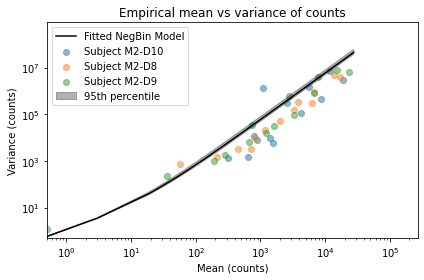

In [13]:
fig = md2.negbin.visualize_learned_negative_binomial_model(mcmc_negbin)
fig.tight_layout()

# Run the model

In [14]:
# Get a0 and a1 from negbin (get the mean of the posterior)
from mdsine2.names import STRNAMES
a0 = md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A0])['mean']
a1 = md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A1])['mean']

print('negbin a0', a0)
print('negbin a1', a1)

basepath = 'output/mdsine2/uc0'
os.makedirs(basepath, exist_ok=True)


# Initialize parameters of the model
params = md2.config.MDSINE2ModelConfig(
    basepath=basepath, seed=0, burnin=50, 
    n_samples=100, negbin_a0=a0, negbin_a1=a1, checkpoint=50)

# The default number of modules is 30, which is larger than the number of taxa
# that we have in this dataset, which would throw a flag.
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'

negbin a0 1.1642672989308661e-13
negbin a1 0.05972242507901712


In [15]:
# initilize the graph
mcmc_uc0 = md2.initialize_graph(params=params, graph_name=uc_toy.name, subjset=uc_toy)


INFO:base.2534: max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
INFO:run.84: Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
INFO:run.251: There are 372 qPCR measurements for 3 buckets. Each bucket is 124 measurements long
INFO:run.286: Initializing Filtering
INFO:posterior.2659: Setting up the essential timepoints
INFO:posterior.2672: Essential timepoints: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.  11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.  37.5 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.  50.5 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.  60.5 61.  62.  63.  64.  64.5]
INFO:run.286: Initializing Zero inflation
INFO:design_matrices.847: Initializing LHS vector
INFO:design_matrices.1012: Initializing growth design matrix
INFO:design_matrices.940: Initializing self-inte

INFO:run.371: 		prior.loc: 0
INFO:run.369: 	perturbation Vancomycin
INFO:run.370: 		value: {100115: 0, 100116: 0, 100117: 0, 100118: 0, 100119: 0, 100120: 0, 100121: 0, 100122: 0, 100123: 0, 100124: 0, 100125: 0, 100126: 0, 100127: 0, 100128: 0, 100129: 0}
INFO:run.371: 		prior.loc: 0
INFO:run.369: 	perturbation Gentamicin
INFO:run.370: 		value: {100115: 0, 100116: 0, 100117: 0, 100118: 0, 100119: 0, 100120: 0, 100121: 0, 100122: 0, 100123: 0, 100124: 0, 100125: 0, 100126: 0, 100127: 0, 100128: 0, 100129: 0}
INFO:run.371: 		prior.loc: 0
INFO:run.372: Perturbation prior variances:
INFO:run.374: 		dof: 2.5
INFO:run.375: 		scale: 2000.0
INFO:run.376: 		value: 10000.0
INFO:run.374: 		dof: 2.5
INFO:run.375: 		scale: 2000.0
INFO:run.376: 		value: 10000.0
INFO:run.374: 		dof: 2.5
INFO:run.375: 		scale: 2000.0
INFO:run.376: 		value: 10000.0
INFO:run.377: Perturbation indicators:
INFO:run.380: 	perturbation High Fat Diet: [False False False False False False False False False False False False 

In [16]:
mcmc_uc0 = md2.run_graph(mcmc_uc0, crash_if_error=True)

INFO:inference.430: 

Inference iteration 0/100, time: 0.0
INFO:inference.439: Cluster interaction indicator parameter: None
INFO:inference.439: Cluster interaction probability: 0.09234190994988938
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: Nones
perturbation High Fat Diet (0/15): [False False False False False False False False False False False False False False False]
perturbation Vancomycin (0/15): [False False False False False False False False False False False False False False False]
perturbation Gentamicin (0/15): [False False False False False False False False False False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.1527842458791451
	perturbation Vancomycin: 0.1527842458791451
	perturbation Gentamicin: 0.1527842458791451
INFO:inference.439: Logistic growth parameters (growth, se

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 9.483892334955561
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -5.633760869066583
	perturbation Vancomycin: -32.394691549238026
	perturbation Gentamicin: 19.22092898194378
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.155360661555971, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.7886622384767377, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 4047.7156572959684
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 204.06655221025355
	perturbation Vancomycin: 1115.7342315369867
	perturbation Gen

INFO:inference.439: Cluster interaction probability: 0.06389609988570996
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.013999700546264648s
perturbation High Fat Diet (1/15): [False False False False False  True False False False False False False False False False]
perturbation Vancomycin (2/15): [False False False False False False False False  True False False False  True False False]
perturbation Gentamicin (2/15): [False False False False False False False  True False False False False  True False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.025066240399094393
	perturbation Vancomycin: 0.09438846925304158
	perturbation Gentamicin: 0.311140162497224
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.05133125 0.35152011 0.35811711 0.31745151 0.483465

INFO:inference.439: Clustering concentration parameter: 2548.488953421099
INFO:posterior.1580: 0/15: 0
INFO:posterior.1580: 1/15: 13
INFO:posterior.1580: 2/15: 14
INFO:posterior.1580: 3/15: 4
INFO:posterior.1580: 4/15: 6
INFO:posterior.1580: 5/15: 8
INFO:posterior.1580: 6/15: 10
INFO:posterior.1580: 7/15: 7
INFO:posterior.1580: 8/15: 1
INFO:posterior.1580: 9/15: 9
INFO:posterior.1580: 10/15: 12
INFO:posterior.1580: 11/15: 2
INFO:posterior.1580: 12/15: 3
INFO:posterior.1580: 13/15: 11
INFO:posterior.1580: 14/15: 5
INFO:inference.430: 

Inference iteration 5/100, time: 0.9051547050476074
INFO:inference.439: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fal

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 5.710958952384468
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 38.518554822402024
	perturbation Vancomycin: 35.59433820706934
	perturbation Gentamicin: -1.776905185472492
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.1500028442148336, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.47231404103632385, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 235.123399281476
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1373.5156501035844
	perturbation Vancomycin: 1947.4789233029717
	perturbation Gent

INFO:inference.439: Cluster interaction probability: 0.01414955107963672
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.012000322341918945s
perturbation High Fat Diet (0/15): [False False False False False False False False False False False False False False False]
perturbation Vancomycin (2/15): [False  True False False False False False False False False  True False False False False]
perturbation Gentamicin (0/15): [False False False False False False False False False False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.04380913321868082
	perturbation Vancomycin: 0.2668272055717504
	perturbation Gentamicin: 0.00015348561567036495
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.43325582 0.30910204 0.47357585 0.11244414 0.662

INFO:inference.439: Filtering: no-mp - Time: 0.2710, Acc: [0.620, 0.638, 0.609, 0.638, 0.603], data/sec: 20759.06
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 15
Cluster 100156
	members: ['OTU_4']
	size: 1
Cluster 100158
	members: ['OTU_6']
	size: 1
Cluster 100160
	members: ['OTU_8']
	size: 1
Cluster 100161
	members: ['OTU_13']
	size: 1
Cluster 100162
	members: ['OTU_1']
	size: 1
Cluster 100163
	members: ['OTU_3']
	size: 1
Cluster 100165
	members: ['OTU_7']
	size: 1
Cluster 100166
	members: ['OTU_9']
	size: 1
Cluster 100168
	members: ['OTU_17']
	size: 1
Cluster 100170
	members: ['OTU_5']
	size: 1
Cluster 100172
	members: ['OTU_16']
	size: 1
Cluster 100174
	members: ['OTU_10']
	size: 1
Cluster 100175
	members: ['OTU_12']
	size: 1
Cluster 100177
	members: ['OTU_18']
	size: 1
Cluster 100179
	members: ['OTU_2']
	size: 1
no mp - Total time: 0.5067129135131836
INFO:inference.439: Clustering concentration paramet

INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.77828705 0.38903905 0.76961277 0.10587474 0.59827022 0.6681632  0.21076414 0.44212117 0.02597526 0.17506687 0.38629987 0.1788002  0.67657752 0.52187184 0.20594952]
Self Interactions:
[ 0.36838934  0.24731934  0.20578355  0.47505948  0.84491244  0.55085404  1.62945113  1.36630626 87.39449338 99.34047228  1.77221516 51.90245568  4.80856796  2.17100663  2.53311716]
Interactions:
[-0.7848822 -1.5365928]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-2.4466524  -2.55542478]
	 perturbation Gentamicin: []
INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -3.680517736892151
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 94.64911690010152
	perturbation Vancomycin: 19.0790281

INFO:posterior.1580: 5/15: 5
INFO:posterior.1580: 6/15: 8
INFO:posterior.1580: 7/15: 2
INFO:posterior.1580: 8/15: 9
INFO:posterior.1580: 9/15: 4
INFO:posterior.1580: 10/15: 1
INFO:posterior.1580: 11/15: 13
INFO:posterior.1580: 12/15: 6
INFO:posterior.1580: 13/15: 10
INFO:posterior.1580: 14/15: 14
INFO:inference.430: 

Inference iteration 13/100, time: 0.8750336170196533
INFO:inference.439: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False F

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 6.1340365274674795
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -46.038793635473446
	perturbation Vancomycin: -68.52683201248524
	perturbation Gentamicin: 97.6005567085997
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.19204162144120313, Acceptance rate: 0.9285714285714286
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.4716932146951434, Acceptance rate: 0.9285714285714286
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 125.28553759886377
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2127.3926028988553
	perturbation Vancomycin: 2708

INFO:inference.439: Cluster interaction probability: 0.013751177599541212
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.009994745254516602s
perturbation High Fat Diet (0/14): [False False False False False False False False False False False False False False]
perturbation Vancomycin (2/14): [False False  True False False False False False False False False  True False False]
perturbation Gentamicin (0/14): [False False False False False False False False False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0037604469149499806
	perturbation Vancomycin: 0.16984116920929612
	perturbation Gentamicin: 4.287775725041615e-06
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.56607291 0.25307775 0.41920211 0.05634966 0.44375933 0.0940781

INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 15
Cluster 100204
	members: ['OTU_1']
	size: 1
Cluster 100206
	members: ['OTU_13']
	size: 1
Cluster 100207
	members: ['OTU_6']
	size: 1
Cluster 100209
	members: ['OTU_18']
	size: 1
Cluster 100211
	members: ['OTU_7']
	size: 1
Cluster 100212
	members: ['OTU_5']
	size: 1
Cluster 100213
	members: ['OTU_4']
	size: 1
Cluster 100215
	members: ['OTU_17']
	size: 1
Cluster 100217
	members: ['OTU_2']
	size: 1
Cluster 100219
	members: ['OTU_16']
	size: 1
Cluster 100221
	members: ['OTU_8']
	size: 1
Cluster 100223
	members: ['OTU_12']
	size: 1
Cluster 100225
	members: ['OTU_3']
	size: 1
Cluster 100227
	members: ['OTU_9']
	size: 1
Cluster 100229
	members: ['OTU_10']
	size: 1
no mp - Total time: 0.504002571105957
INFO:inference.439: Clustering concentration parameter: 3270.220016260282
INFO:inference.430: 

Inference iteration 18/100, time: 0.36696910858154297
INFO:inference.43

INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.29370246 0.38591378 0.18303771 0.02926764 0.70426002 0.1291165  0.30920011 0.37296189 0.07103688 0.15129718 0.55530364 0.28536917 0.54757863 0.64553485 0.4540806 ]
Self Interactions:
[  0.24768225   0.40205482   0.16374552   8.95587355   1.04247776   0.68944755   1.33575728   1.21051782 125.89356317  91.02571771   2.9179503   81.42438581   2.95497357   4.37810375   4.73845091]
Interactions:
[]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-4.15255926 -2.07334606]
	 perturbation Gentamicin: []
INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -13.026265366294602
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -110.04810459747449
	perturbation Vancomycin: -30.579706048

INFO:posterior.1580: 7/15: 8
INFO:posterior.1580: 8/15: 2
INFO:posterior.1580: 9/15: 9
INFO:posterior.1580: 10/15: 11
INFO:posterior.1580: 11/15: 7
INFO:posterior.1580: 12/15: 12
INFO:posterior.1580: 13/15: 0
INFO:posterior.1580: 14/15: 5
INFO:inference.430: 

Inference iteration 21/100, time: 0.8646225929260254
INFO:inference.439: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False 

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 27.652104631790984
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -44.37818270744558
	perturbation Vancomycin: -21.383706518591907
	perturbation Gentamicin: -129.69452957321846
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.23744028888703927, Acceptance rate: 0.9545454545454546
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.44840227843026, Acceptance rate: 0.9545454545454546
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 39.162105384355
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3535.408495278542
	perturbation Vancomycin: 1804.53

INFO:inference.439: Cluster interaction probability: 0.0008981278085360077
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.010003805160522461s
perturbation High Fat Diet (0/15): [False False False False False False False False False False False False False False False]
perturbation Vancomycin (3/15): [False False False False False  True False False False False False False  True False  True]
perturbation Gentamicin (0/15): [False False False False False False False False False False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.056565665203912145
	perturbation Vancomycin: 0.1348478688877273
	perturbation Gentamicin: 0.0004915438369254233
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.62734541 0.44127795 0.41481292 0.23076712 0.5

INFO:inference.439: Filtering: no-mp - Time: 0.2510, Acc: [0.632, 0.609, 0.648, 0.635, 0.600], data/sec: 22413.37
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 14
Cluster 100256
	members: ['OTU_2']
	size: 1
Cluster 100258
	members: ['OTU_9']
	size: 1
Cluster 100260
	members: ['OTU_3']
	size: 1
Cluster 100261
	members: ['OTU_7']
	size: 1
Cluster 100263
	members: ['OTU_12']
	size: 1
Cluster 100265
	members: ['OTU_17']
	size: 1
Cluster 100267
	members: ['OTU_4']
	size: 1
Cluster 100268
	members: ['OTU_18']
	size: 1
Cluster 100270
	members: ['OTU_8']
	size: 1
Cluster 100272
	members: ['OTU_1']
	size: 1
Cluster 100274
	members: ['OTU_10', 'OTU_6']
	size: 2
Cluster 100276
	members: ['OTU_13']
	size: 1
Cluster 100278
	members: ['OTU_16']
	size: 1
Cluster 100279
	members: ['OTU_5']
	size: 1
no mp - Total time: 0.5115501880645752
INFO:inference.439: Clustering concentration parameter: 31812.98023002288
INFO:inferenc

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 216.0711656622921
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 12.103465320243336
	perturbation Vancomycin: 36.95050187271609
	perturbation Gentamicin: -77.6411666680021
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.1724545927159885, Acceptance rate: 0.9629629629629629
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 4.00528704708668, Acceptance rate: 0.9629629629629629
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 432.4841388491492
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1977.0526500756528
	perturbation Vancomycin: 1756.76028

INFO:inference.439: Cluster interaction probability: 0.008404940582929198
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.010004043579101562s
perturbation High Fat Diet (0/13): [False False False False False False False False False False False False False]
perturbation Vancomycin (1/13): [False False False False False  True False False False False False False False]
perturbation Gentamicin (1/13): [False False False False  True False False False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.02142678933032397
	perturbation Vancomycin: 0.11757863916064848
	perturbation Gentamicin: 0.025899308693583364
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.72190496 0.57119454 0.72178933 0.02099413 0.68982347 0.1611206  0.40493942 0.199613

INFO:inference.439: Clustering concentration parameter: 229.28960964489602
INFO:inference.430: 

Inference iteration 31/100, time: 0.3370378017425537
INFO:inference.439: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fa

INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1911.5561420524598
	perturbation Vancomycin: 1048.485926238085
	perturbation Gentamicin: 16176.28324755816
INFO:inference.439: Process Variance parameter: 3.6245221040935434, empirical_variance: 3.54267
INFO:inference.439: Filtering: no-mp - Time: 0.2520, Acc: [0.627, 0.611, 0.631, 0.615, 0.613], data/sec: 22320.93
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 13
Cluster 100267
	members: ['OTU_2']
	size: 1
Cluster 100283
	members: ['OTU_16']
	size: 1
Cluster 100284
	members: ['OTU_1']
	size: 1
Cluster 100286
	members: ['OTU_13', 'OTU_10']
	size: 2
Cluster 100287
	members: ['OTU_4']
	size: 1
Cluster 100289
	members: ['OTU_8']
	size: 1
Cluster 100291
	members: ['OTU_3', 'OTU_18']
	size: 2
Cluster 100293
	members: ['OTU_7']
	size: 1
Cluster 100294
	membe

INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.69365478 0.4681807  0.80974323 0.23503787 0.42963151 0.62235426 0.19566671 0.38184099 0.23193871 0.20930173 0.57757694 0.1602437  0.79496203 0.60144929 0.61842047]
Self Interactions:
[  0.46284325   0.2856472    0.29904691   5.6000427    0.87449228   0.64369303   1.58086019   1.70824993 153.58397033 196.26046715   2.42600308  66.29202873   4.44181983   3.97301633   6.58354745]
Interactions:
[-0.27184924]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-2.55970475 -2.48285028]
	 perturbation Gentamicin: []
INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -0.9175746763015655
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -98.9223609485391
	perturbation Vancomycin: 5.39

INFO:inference.439: Cluster interaction probability: 0.010019962649802453
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.009000778198242188s
perturbation High Fat Diet (0/12): [False False False False False False False False False False False False]
perturbation Vancomycin (2/12): [ True  True False False False False False False False False False False]
perturbation Gentamicin (0/12): [False False False False False False False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0055196428382226275
	perturbation Vancomycin: 0.08088376996341635
	perturbation Gentamicin: 0.009283658464158398
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.67823459 0.45984652 0.83495316 0.32274834 0.61509206 0.69468169 0.39988257 0.56562717 0.24061606 0.

INFO:inference.439: Clustering concentration parameter: 15.34071160806143
INFO:inference.430: 

Inference iteration 38/100, time: 0.3230295181274414
INFO:inference.439: Cluster interaction indicator parameter: [False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False]
total time: 0.033995628356933594, n_interactions: 1/110, 0.01
INFO:inference.439: Cluster interaction probability: 0.01874427708

INFO:inference.439: Clustering concentration parameter: 28.75973797176516
INFO:inference.430: 

Inference iteration 40/100, time: 0.3170039653778076
INFO:inference.439: Cluster interaction indicator parameter: [False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False]
total time: 0.03702974319458008, n_interactions: 2/110, 0.02
INFO:inference.439: Cluster interaction probability: 0.022598356085

INFO:inference.439: Process Variance parameter: 3.2777488333205897, empirical_variance: 3.30224
INFO:inference.439: Filtering: no-mp - Time: 0.2540, Acc: [0.628, 0.632, 0.629, 0.601, 0.599], data/sec: 22144.86
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 13
Cluster 100306
	members: ['OTU_6', 'OTU_17']
	size: 2
Cluster 100342
	members: ['OTU_4', 'OTU_12']
	size: 2
Cluster 100345
	members: ['OTU_9']
	size: 1
Cluster 100347
	members: ['OTU_3']
	size: 1
Cluster 100348
	members: ['OTU_13']
	size: 1
Cluster 100350
	members: ['OTU_16']
	size: 1
Cluster 100352
	members: ['OTU_10']
	size: 1
Cluster 100353
	members: ['OTU_1']
	size: 1
Cluster 100355
	members: ['OTU_7']
	size: 1
Cluster 100356
	members: ['OTU_8']
	size: 1
Cluster 100359
	members: ['OTU_5']
	size: 1
Cluster 100361
	members: ['OTU_18']
	size: 1
Cluster 100363
	members: ['OTU_2']
	size: 1
no mp - Total time: 0.4380364418029785
INFO:inference.439: Cluste

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -7.717845280799569
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 48.038800498666575
	perturbation Vancomycin: 7.461583932017077
	perturbation Gentamicin: 187.8553153027855
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.7561403902999988, Acceptance rate: 0.9534883720930233
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 4.414960475362338, Acceptance rate: 0.9767441860465116
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 234.11812254459113
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3848.9144567762455
	perturbation Vancomycin: 516.528

INFO:inference.439: Cluster interaction probability: 0.0499169820929027
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.009997367858886719s
perturbation High Fat Diet (0/14): [False False False False False False False False False False False False False False]
perturbation Vancomycin (3/14): [ True False  True False False False  True False False False False False False False]
perturbation Gentamicin (0/14): [False False False False False False False False False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.002189390859266743
	perturbation Vancomycin: 0.3293227241042134
	perturbation Gentamicin: 0.01640935982992784
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.62970117 0.13444772 0.75312494 0.15043003 0.64959174 0.48351938 0.26

INFO:inference.439: Clustering concentration parameter: 167.85474577320244
INFO:inference.430: 

Inference iteration 47/100, time: 0.35500001907348633
INFO:inference.439: Cluster interaction indicator parameter: [False False False False False False False False  True False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False  True False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False  True False False False False False False False F

INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.6530050194723781, Acceptance rate: 0.9583333333333334
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 5.028015165228264, Acceptance rate: 0.9791666666666666
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 1700.1345579200354
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3468.6276524218583
	perturbation Vancomycin: 4615.7517047354395
	perturbation Gentamicin: 6311.954998707005
INFO:inference.439: Process Variance parameter: 3.122341694909778, empirical_variance: 3.14603
INFO:inference.439: Filtering: no-mp - Time: 0.2590, Acc: [0.612, 0.615, 0.633, 0.610, 0.614], data/sec: 21720.92
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluste

INFO:inference.439: Cluster interaction probability: 0.05970816329349733
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.013027667999267578s
perturbation High Fat Diet (0/13): [False False False False False False False False False False False False False]
perturbation Vancomycin (1/13): [ True False False False False False False False False False False False False]
perturbation Gentamicin (0/13): [False False False False False False False False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.01610666860058421
	perturbation Vancomycin: 0.014636698232858535
	perturbation Gentamicin: 0.0007642645604091442
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.60769308 0.32504927 0.58488658 0.25408581 0.57834118 0.56531363 0.82844725 0.34901

INFO:inference.439: Clustering concentration parameter: 25.01986315127886
INFO:inference.430: 

Inference iteration 52/100, time: 0.3671846389770508
INFO:inference.439: Cluster interaction indicator parameter: [False  True False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False  True False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False Fal

INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.23350775446399574, Acceptance rate: 0.96
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 6.662571729713365, Acceptance rate: 0.98
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 2378.170773148202
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 8868.51818703299
	perturbation Vancomycin: 37256.377644717395
	perturbation Gentamicin: 9406.56809747608
INFO:inference.439: Process Variance parameter: 2.8568651876071316, empirical_variance: 2.90207
INFO:inference.439: Filtering: no-mp - Time: 0.2697, Acc: [0.647, 0.628, 0.621, 0.600, 0.595], data/sec: 20859.56
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 13

INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.02661889958097562
	perturbation Vancomycin: 0.3556482647379822
	perturbation Gentamicin: 0.0008265788619145001
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.44108532 0.45273117 0.58964431 0.33305507 0.72633823 0.88708654 0.49223344 0.50273029 0.37209497 0.04333768 0.51876258 0.18577441 1.15059718 0.93856449 0.36318686]
Self Interactions:
[3.56458408e-01 2.72560724e-01 3.08849433e-01 2.10188813e+00 1.48356241e+00 4.74665583e-01 8.52728946e-01 1.59027260e+00 3.22417545e+02 2.15794796e+02 2.10743967e+00 9.71568903e+01 3.50855632e+00 3.72412763e+00 4.19418915e+00]
Interactions:
[ -0.23492287 -63.94281668 -85.44841274  -0.41951026 -59.48595247  16.62438204 -91.66006103]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: [

INFO:posterior.1580: 6/15: 6
INFO:posterior.1580: 7/15: 2
INFO:posterior.1580: 8/15: 14
INFO:posterior.1580: 9/15: 4
INFO:posterior.1580: 10/15: 13
INFO:posterior.1580: 11/15: 10
INFO:posterior.1580: 12/15: 0
INFO:posterior.1580: 13/15: 9
INFO:posterior.1580: 14/15: 12
INFO:inference.430: 

Inference iteration 57/100, time: 0.7750296592712402
INFO:inference.439: Cluster interaction indicator parameter: [False  True False False False False False False False False False False False False False  True False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False  True False False False False False False  True False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False

INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 833.8398140167304
	perturbation Vancomycin: 2335.488499820974
	perturbation Gentamicin: 600.0012880637872
INFO:inference.439: Process Variance parameter: 2.727382866016019, empirical_variance: 2.75150
INFO:inference.439: Filtering: no-mp - Time: 0.2670, Acc: [0.616, 0.610, 0.612, 0.612, 0.620], data/sec: 21070.02
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 11
Cluster 100306
	members: ['OTU_6', 'OTU_7', 'OTU_17', 'OTU_16']
	size: 4
Cluster 100422
	members: ['OTU_4']
	size: 1
Cluster 100435
	members: ['OTU_9']
	size: 1
Cluster 100437
	members: ['OTU_13']
	size: 1
Cluster 100439
	members: ['OTU_2']
	size: 1
Cluster 100443
	members: ['OTU_8']
	size: 1
Cluster 100446
	members: ['OTU_3']
	size: 1
Cluster 100447
	members: ['OTU_18', 'OTU_5']
	size: 2
Clust

INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 142.49318051218776
	perturbation Vancomycin: -9.339611811059374
	perturbation Gentamicin: 209.83155114509762
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.3653723292633788, Acceptance rate: 0.94
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 5.7373255098705656, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 2137.9592511965648
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 51320.02899250236
	perturbation Vancomycin: 2269.3298334321266
	perturbation Gentamicin: 1085.5334950637473
INFO:inference.439: Process Variance parameter: 2.6816700065942016, empiric

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -42.60206871601578
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 91.71350860592803
	perturbation Vancomycin: -84.97878952423378
	perturbation Gentamicin: -79.94307428339097
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.6841325195592639, Acceptance rate: 0.96
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 4.8857914636557105, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 740.6687918739885
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2433.3665096511595
	perturbation Vancomycin: 3274.1995571166844
	perturbation Ge

INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 4.940652561724175, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 67.27787752680678
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 7083.4424133845105
	perturbation Vancomycin: 791.2595932937634
	perturbation Gentamicin: 901.1979323471468
INFO:inference.439: Process Variance parameter: 2.82506823944121, empirical_variance: 2.72639
INFO:inference.439: Filtering: no-mp - Time: 0.2530, Acc: [0.625, 0.623, 0.610, 0.597, 0.644], data/sec: 22236.13
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 8
Cluster 100306
	members: ['OTU_7', 'OTU_16', 'OTU_6', 'OTU_17']
	size: 4
Cluster 100446
	members: ['OTU_18']
	size: 1
Cluster 100450
	members:

INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4185.730309091
	perturbation Vancomycin: 1926.9646025477186
	perturbation Gentamicin: 1944.6291363194382
INFO:inference.439: Process Variance parameter: 2.799553427613666, empirical_variance: 2.71830
INFO:inference.439: Filtering: no-mp - Time: 0.2700, Acc: [0.633, 0.628, 0.624, 0.604, 0.613], data/sec: 20833.32
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 7
Cluster 100306
	members: ['OTU_17', 'OTU_6', 'OTU_16', 'OTU_7']
	size: 4
Cluster 100450
	members: ['OTU_8', 'OTU_12']
	size: 2
Cluster 100460
	members: ['OTU_5', 'OTU_3', 'OTU_2', 'OTU_13', 'OTU_9']
	size: 5
Cluster 100470
	members: ['OTU_10']
	size: 1
Cluster 100482
	members: ['OTU_4']
	size: 1
Cluster 100484
	members: ['OTU_18']
	size: 1
Cluster 100486
	members: ['OTU_1']
	size: 1
no mp - Total

INFO:inference.439: Clustering concentration parameter: 6.721868149321522
INFO:posterior.1580: 0/15: 10
INFO:posterior.1580: 1/15: 5
INFO:posterior.1580: 2/15: 12
INFO:posterior.1580: 3/15: 1
INFO:posterior.1580: 4/15: 14
INFO:posterior.1580: 5/15: 0
INFO:posterior.1580: 6/15: 13
INFO:posterior.1580: 7/15: 8
INFO:posterior.1580: 8/15: 4
INFO:posterior.1580: 9/15: 3
INFO:posterior.1580: 10/15: 9
INFO:posterior.1580: 11/15: 6
INFO:posterior.1580: 12/15: 11
INFO:posterior.1580: 13/15: 7
INFO:posterior.1580: 14/15: 2
INFO:inference.430: 

Inference iteration 69/100, time: 0.586029052734375
INFO:inference.439: Cluster interaction indicator parameter: [ True False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False  True False False False False False  True False False]
total time: 0.018999814987182617, n_interactions: 4/42, 0.10
INFO:inference.439: Cluster int

INFO:inference.439: Clustering concentration parameter: 9.151992762607879
INFO:inference.430: 

Inference iteration 71/100, time: 0.32107090950012207
INFO:inference.439: Cluster interaction indicator parameter: [ True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False]
total time: 0.033023834228515625, n_interactions: 2/72, 0.03
INFO:inference.439: Cluster interaction probability: 0.023678071623027385
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.009000062942504883s
perturbation High Fat Diet (0/9): [False False False False False False False False False]
perturbation Vancomyci

INFO:posterior.1580: 5/15: 7
INFO:posterior.1580: 6/15: 4
INFO:posterior.1580: 7/15: 9
INFO:posterior.1580: 8/15: 3
INFO:posterior.1580: 9/15: 8
INFO:posterior.1580: 10/15: 2
INFO:posterior.1580: 11/15: 5
INFO:posterior.1580: 12/15: 10
INFO:posterior.1580: 13/15: 13
INFO:posterior.1580: 14/15: 0
INFO:inference.430: 

Inference iteration 73/100, time: 0.6410081386566162
INFO:inference.439: Cluster interaction indicator parameter: [ True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False]
total time: 0.025023698806762695, n_interactions: 2/72, 0.03
INFO:inference.439: Cluster interaction probability: 0.00551391239836480

INFO:inference.439: Cluster interaction probability: 0.09615629698599083
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.0070264339447021484s
perturbation High Fat Diet (0/7): [False False False False False False False]
perturbation Vancomycin (2/7): [ True  True False False False False False]
perturbation Gentamicin (0/7): [False False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.07055252547867205
	perturbation Vancomycin: 0.21679637208689612
	perturbation Gentamicin: 0.15943114513472303
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.58180896 0.40364837 0.73268812 0.35314504 0.64892432 0.44836342 0.63747414 0.38092564 0.17957001 0.07750169 0.38696327 0.23151725 0.85152746 0.83222982 0.34934968]
Self Interactions:
[3.13420711e

INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.05740909635727038
	perturbation Vancomycin: 0.11889499576280375
	perturbation Gentamicin: 0.12084489072900553
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.51419088 0.55654982 0.83152267 0.21862966 0.8539318  0.42436684 0.47976834 0.25793995 0.30298533 0.12832345 0.48944029 0.31329093 0.69902029 1.05919132 0.39407051]
Self Interactions:
[4.38240831e-01 2.94735800e-01 3.53707205e-01 6.68934733e+00 1.18384933e+00 2.07713147e-01 7.89525940e-01 9.59882987e-01 2.08988306e+02 2.05262110e+02 2.81196662e+00 1.67083907e+02 2.51756908e+00 3.05547595e+00 4.02480033e+00]
Interactions:
[  -0.13247129 -118.56040454]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.06306372]
	 perturbation Gentam

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -29.940750414982926
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 78.02413459496853
	perturbation Vancomycin: -21.79152503631502
	perturbation Gentamicin: 14.851876101153549
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.41037951475537304, Acceptance rate: 0.94
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 5.351567900249912, Acceptance rate: 0.98
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 263.49239734214933
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4357.852979956334
	perturbation Vancomycin: 1491.578462077849
	perturbation G

INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.2644724587349503, Acceptance rate: 0.94
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 5.174277792347437, Acceptance rate: 0.98
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 442.5587272362454
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2061.7603702440333
	perturbation Vancomycin: 3005.219386765508
	perturbation Gentamicin: 1573.9969729207437
INFO:inference.439: Process Variance parameter: 2.429143977377836, empirical_variance: 2.41527
INFO:inference.439: Filtering: no-mp - Time: 0.2670, Acc: [0.639, 0.612, 0.639, 0.624, 0.621], data/sec: 21066.08
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 7

INFO:inference.439: Filtering: no-mp - Time: 0.2580, Acc: [0.614, 0.614, 0.593, 0.640, 0.613], data/sec: 21805.24
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 7
Cluster 100306
	members: ['OTU_16', 'OTU_7', 'OTU_6', 'OTU_17']
	size: 4
Cluster 100504
	members: ['OTU_12', 'OTU_5', 'OTU_2']
	size: 3
Cluster 100517
	members: ['OTU_8', 'OTU_3']
	size: 2
Cluster 100530
	members: ['OTU_10', 'OTU_18', 'OTU_13']
	size: 3
Cluster 100545
	members: ['OTU_4']
	size: 1
Cluster 100548
	members: ['OTU_9']
	size: 1
Cluster 100558
	members: ['OTU_1']
	size: 1
no mp - Total time: 0.23303914070129395
INFO:inference.439: Clustering concentration parameter: 2.912980792429929
INFO:inference.430: 

Inference iteration 84/100, time: 0.32200074195861816
INFO:inference.439: Cluster interaction indicator parameter: [ True False  True False  True False False False False False  True False False False False False  True False False  True 

INFO:inference.439: Clustering concentration parameter: 1.476972424136275
INFO:inference.430: 

Inference iteration 86/100, time: 0.3129730224609375
INFO:inference.439: Cluster interaction indicator parameter: [ True False False False False False False False False False False False False False False False False False False False]
total time: 0.011998653411865234, n_interactions: 1/20, 0.05
INFO:inference.439: Cluster interaction probability: 0.1811227102791614
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.005023002624511719s
perturbation High Fat Diet (0/5): [False False False False False]
perturbation Vancomycin (1/5): [ True False False False False]
perturbation Gentamicin (1/5): [False False  True False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.12897044933094862
	perturbation Vancomycin: 0.41788663021063804
	

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -15.315378952399707
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -86.02279764881698
	perturbation Vancomycin: -14.871550485458824
	perturbation Gentamicin: 7.176581086065954
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.048332522469662575, Acceptance rate: 0.96
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 7.710923579708625, Acceptance rate: 0.98
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 145.08058287185017
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 794.0614406469742
	perturbation Vancomycin: 3201.321533168586
	perturbation

INFO:inference.439: Process Variance parameter: 2.3666360213030675, empirical_variance: 2.33879
INFO:inference.439: Filtering: no-mp - Time: 0.2710, Acc: [0.613, 0.619, 0.612, 0.607, 0.610], data/sec: 20758.47
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 100306
	members: ['OTU_16', 'OTU_6', 'OTU_17', 'OTU_7']
	size: 4
Cluster 100504
	members: ['OTU_2', 'OTU_12', 'OTU_10', 'OTU_4', 'OTU_1', 'OTU_9']
	size: 6
Cluster 100517
	members: ['OTU_8', 'OTU_3', 'OTU_5']
	size: 3
Cluster 100563
	members: ['OTU_18', 'OTU_13']
	size: 2
no mp - Total time: 0.18402886390686035
INFO:inference.439: Clustering concentration parameter: 0.2552207884434831
INFO:inference.430: 

Inference iteration 91/100, time: 0.29799818992614746
INFO:inference.439: Cluster interaction indicator parameter: [ True False False False False False False False False False False False]
total time: 0.009998321533203125, n_interactions: 1/12,

INFO:inference.439: Cluster interaction probability: 0.010473475165487748
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.0049893856048583984s
perturbation High Fat Diet (0/5): [False False False False False]
perturbation Vancomycin (2/5): [ True False False False  True]
perturbation Gentamicin (1/5): [False False  True False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.007920894121977273
	perturbation Vancomycin: 0.2082716368850871
	perturbation Gentamicin: 0.15663296938069554
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.55887976 0.50476287 0.71501496 0.11085446 0.48383508 0.72350223 0.3230901  0.52907524 0.00744005 0.05912055 0.77599871 0.20326607 1.0210944  0.85565753 0.51797642]
Self Interactions:
[3.22109276e-01 2.06196905e-01 2.50359954e-01 1

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 7.787418854172085
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -55.20596928326981
	perturbation Vancomycin: 37.396533851143445
	perturbation Gentamicin: -23.0835245908347
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.08191619786164617, Acceptance rate: 0.96
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 9.015086663381473, Acceptance rate: 0.98
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 174.01108764353486
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4048.820262435757
	perturbation Vancomycin: 3338.127990412214
	perturbation Gen

INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 845.568176309266
	perturbation Vancomycin: 1971.5560611096585
	perturbation Gentamicin: 3912.77339812523
INFO:inference.439: Process Variance parameter: 2.299576744930418, empirical_variance: 2.36245
INFO:inference.439: Filtering: no-mp - Time: 0.2570, Acc: [0.602, 0.599, 0.590, 0.612, 0.624], data/sec: 21887.14
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 7
Cluster 100306
	members: ['OTU_7', 'OTU_17', 'OTU_6', 'OTU_16']
	size: 4
Cluster 100504
	members: ['OTU_1', 'OTU_12', 'OTU_9', 'OTU_2']
	size: 4
Cluster 100517
	members: ['OTU_8', 'OTU_10', 'OTU_3']
	size: 3
Cluster 100607
	members: ['OTU_5']
	size: 1
Cluster 100610
	members: ['OTU_13']
	size: 1
Cluster 100611
	members: ['OTU_4']
	size: 1
Cluster 100616
	members: ['OTU_18']
	size: 1
no mp - Total

INFO:inference.439: Clustering concentration parameter: 1.6851928331085522
INFO:inference.471: Inference total time: 0.4395695662498474/Gibb step
INFO:inference.475: remove local traces
INFO:run.544: Denormalizing the parameters


INFO:util.169: Number of clusters: 7
INFO:util.175: Clusters assigned: [0 0 4 1 6 3 3 4 0 1 0 5 3 3 2]


Cluster 0
	 Parasutterella excrementihominis OTU_5
Cluster 1
	 * Phocaeicola OTU_1
	 Bacteroides fragilis/ovatus OTU_2
	 * Bacteroides OTU_9
	 Parabacteroides distasonis OTU_12
Cluster 2
	 * Bacteroides OTU_4
	 Bacteroides uniformis OTU_10
Cluster 3
	 Parabacteroides merdae OTU_18
Cluster 4
	 Bacteroides fragilis/dorei OTU_6
	 Bacteroides caccae OTU_7
	 * Enterocloster OTU_16
	 Murimonas intestini OTU_17
Cluster 5
	 Akkermansia muciniphila OTU_3
	 Bacteroides salyersiae OTU_8
Cluster 6
	 Parabacteroides goldsteinii OTU_13


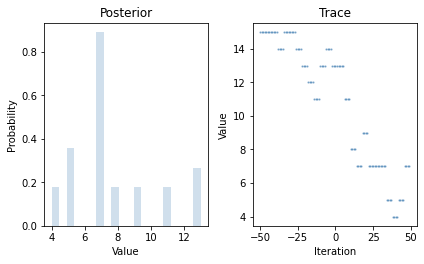

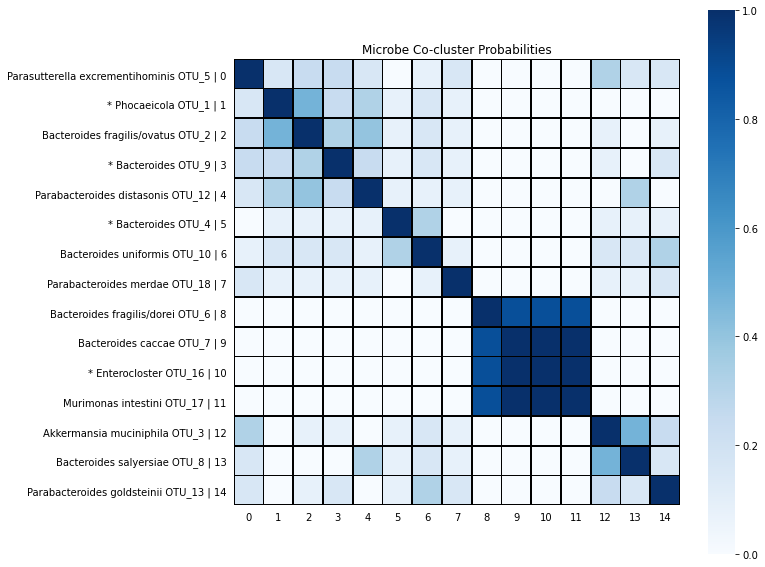

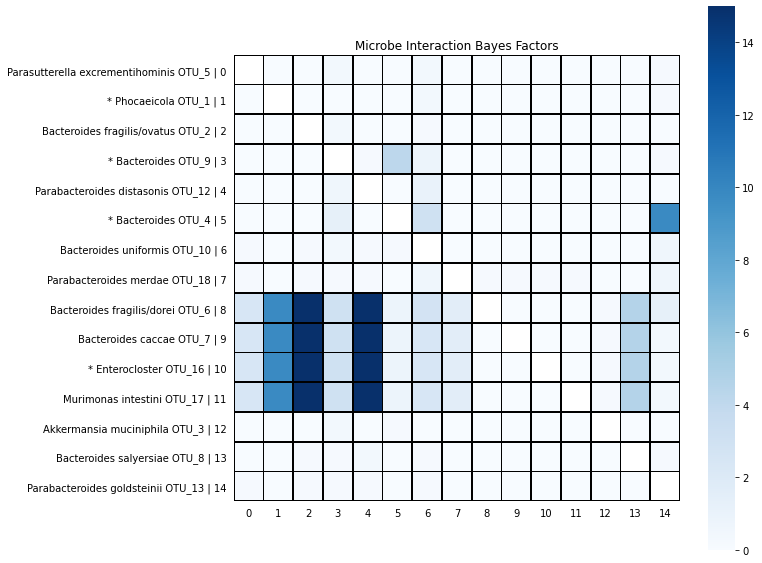

In [17]:
clustering = mcmc_uc0.graph[STRNAMES.CLUSTERING_OBJ]
md2.generate_cluster_assignments_posthoc(clustering, set_as_value=True)
taxa = mcmc_uc0.graph.data.taxa

md2.visualization.render_trace(clustering.n_clusters)
order = []
for i, cluster in enumerate(clustering):
    print('Cluster {}'.format(i))
    for oidx in cluster:
        print('\t', md2.taxaname_for_paper(taxa[oidx], taxa))
        order.append(oidx)

coclusters = md2.summary(mcmc_uc0.graph[STRNAMES.CLUSTERING_OBJ].coclusters)['mean']
md2.visualization.render_cocluster_probabilities(coclusters, taxa=uc_toy.taxa,
    yticklabels='%(paperformat)s | %(index)s', order=order)

bayes_factors = md2.generate_interation_bayes_factors_posthoc(mcmc_uc0)
md2.visualization.render_bayes_factors(
    bayes_factors, taxa=taxa, yticklabels='%(paperformat)s | %(index)s',
    order=order)
plt.show()

# Calculating  $\hat{r}$

In [18]:
params = md2.config.MDSINE2ModelConfig(
    basepath='output/mdsine2/uc100', seed=100, burnin=50, 
    n_samples=100, negbin_a0=a0, negbin_a1=a1, 
    checkpoint=50)
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'
mcmc_uc1 = md2.initialize_graph(params=params, graph_name=uc_toy.name, subjset=uc_toy)
mcmc_uc1 = md2.run_graph(mcmc_uc1, crash_if_error=True)


INFO:base.2534: max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
INFO:run.84: Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
INFO:run.251: There are 372 qPCR measurements for 3 buckets. Each bucket is 124 measurements long
INFO:run.286: Initializing Filtering
INFO:posterior.2659: Setting up the essential timepoints
INFO:posterior.2672: Essential timepoints: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.  11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.  37.5 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.  50.5 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.  60.5 61.  62.  63.  64.  64.5]
INFO:run.286: Initializing Zero inflation
INFO:design_matrices.847: Initializing LHS vector
INFO:design_matrices.1012: Initializing growth design matrix
INFO:design_matrices.940: Initializing self-inte

INFO:run.371: 		prior.loc: 0
INFO:run.369: 	perturbation Vancomycin
INFO:run.370: 		value: {100115: 0, 100116: 0, 100117: 0, 100118: 0, 100119: 0, 100120: 0, 100121: 0, 100122: 0, 100123: 0, 100124: 0, 100125: 0, 100126: 0, 100127: 0, 100128: 0, 100129: 0}
INFO:run.371: 		prior.loc: 0
INFO:run.369: 	perturbation Gentamicin
INFO:run.370: 		value: {100115: 0, 100116: 0, 100117: 0, 100118: 0, 100119: 0, 100120: 0, 100121: 0, 100122: 0, 100123: 0, 100124: 0, 100125: 0, 100126: 0, 100127: 0, 100128: 0, 100129: 0}
INFO:run.371: 		prior.loc: 0
INFO:run.372: Perturbation prior variances:
INFO:run.374: 		dof: 2.5
INFO:run.375: 		scale: 2000.0
INFO:run.376: 		value: 10000.0
INFO:run.374: 		dof: 2.5
INFO:run.375: 		scale: 2000.0
INFO:run.376: 		value: 10000.0
INFO:run.374: 		dof: 2.5
INFO:run.375: 		scale: 2000.0
INFO:run.376: 		value: 10000.0
INFO:run.377: Perturbation indicators:
INFO:run.380: 	perturbation High Fat Diet: [False False False False False False False False False False False False 

INFO:inference.439: Cluster interaction probability: 0.6902120211131538
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.024999380111694336s
perturbation High Fat Diet (9/15): [ True  True False  True False  True False  True  True  True False  True  True False False]
perturbation Vancomycin (11/15): [False  True False  True  True  True  True  True  True False  True False  True  True  True]
perturbation Gentamicin (11/15): [False  True  True False  True False False  True  True  True  True  True  True  True  True]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.543380172150942
	perturbation Vancomycin: 0.6541798484844479
	perturbation Gentamicin: 0.5771423101278725
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.12171643 0.39229091 0.74647098 0.36933789 0.76639724

INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.24935488589151739
	perturbation Vancomycin: 0.39478510894188606
	perturbation Gentamicin: 0.0836243339418902
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.02026563 0.20128539 0.7419323  0.02047319 0.73338937 0.55885879 0.23532478 0.36486274 0.17748172 0.30274626 0.0431157  0.29107326 1.28805679 0.72884907 0.17401487]
Self Interactions:
[9.18655524e-02 1.38047429e-01 2.27791916e-01 1.17697157e+00 1.51039381e+00 4.71091481e-01 2.61297844e-01 8.71438273e-01 6.35525406e+01 1.20543130e+02 1.51028935e-01 1.08117117e+02 4.55128167e+00 1.40742205e+00 4.37614901e+00]
Interactions:
[-9.32740112e+00  4.58207766e+01  6.39503961e-01 -3.69532773e+01 -3.87413142e+01 -6.39760566e-01  4.71188349e+00  1.06267818e+00  4.21912719e+00 -4.41174488e+01  9.84841289e-02 -4.64

INFO:inference.439: Process Variance parameter: 4.657837695315136, empirical_variance: 4.58982
INFO:inference.439: Filtering: no-mp - Time: 0.2520, Acc: [0.627, 0.596, 0.604, 0.618, 0.609], data/sec: 22317.37
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 15
Cluster 100115
	members: ['OTU_1']
	size: 1
Cluster 100116
	members: ['OTU_2']
	size: 1
Cluster 100117
	members: ['OTU_3']
	size: 1
Cluster 100118
	members: ['OTU_4']
	size: 1
Cluster 100119
	members: ['OTU_5']
	size: 1
Cluster 100120
	members: ['OTU_6']
	size: 1
Cluster 100121
	members: ['OTU_7']
	size: 1
Cluster 100122
	members: ['OTU_8']
	size: 1
Cluster 100123
	members: ['OTU_9']
	size: 1
Cluster 100124
	members: ['OTU_10']
	size: 1
Cluster 100125
	members: ['OTU_12']
	size: 1
Cluster 100126
	members: ['OTU_13']
	size: 1
Cluster 100127
	members: ['OTU_16']
	size: 1
Cluster 100128
	members: ['OTU_17']
	size: 1
Cluster 100129
	members: ['OTU_18']
	size

INFO:inference.439: Cluster interaction probability: 0.05671825787353486
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.014031410217285156s
perturbation High Fat Diet (2/14): [False False False  True False False False False False False False False  True False]
perturbation Vancomycin (3/14): [False False False False False  True False  True False False False  True False False]
perturbation Gentamicin (2/14): [False False False False False  True False False False False False False False  True]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.08997769129193614
	perturbation Vancomycin: 0.10182442866807949
	perturbation Gentamicin: 0.13546862620523445
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.23396469 0.05071815 0.56351721 0.05928085 0.59848133 0.81233107 0.3

INFO:inference.439: Clustering concentration parameter: 814.7881386996507
INFO:inference.430: 

Inference iteration 7/100, time: 0.3639976978302002
INFO:inference.439: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False  True False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fals

INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.681256760271574, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 19.204671279966163
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4726.522475446529
	perturbation Vancomycin: 920.3966540624184
	perturbation Gentamicin: 2842.6896368211287
INFO:inference.439: Process Variance parameter: 4.57136289212544, empirical_variance: 4.49642
INFO:inference.439: Filtering: no-mp - Time: 0.2601, Acc: [0.620, 0.612, 0.616, 0.612, 0.589], data/sec: 21623.33
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 14
Cluster 100123
	members: ['OTU_1']
	size: 1
Cluster 100131
	members: ['OTU_2']
	size: 1
Cluster 100133
	members: ['OTU_8']
	size: 1
Cluster 

INFO:inference.439: Cluster interaction probability: 0.019219317008995093
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.011998414993286133s
perturbation High Fat Diet (0/15): [False False False False False False False False False False False False False False False]
perturbation Vancomycin (3/15): [False False False False False False False False False False  True False  True False  True]
perturbation Gentamicin (0/15): [False False False False False False False False False False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.08808733362940692
	perturbation Vancomycin: 0.16548392662984784
	perturbation Gentamicin: 0.04465982534026625
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.49198016 0.21030692 0.64095101 0.06186192 0.9454

INFO:inference.439: Clustering concentration parameter: 123.45332759751007
INFO:inference.430: 

Inference iteration 12/100, time: 0.3625168800354004
INFO:inference.439: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fa

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -39.73152013243986
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 116.09568866615393
	perturbation Vancomycin: -37.50588508882709
	perturbation Gentamicin: 8.101294681824909
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.015456397001164, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.6961580315156832, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 256.2391045076869
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1261.8747107356699
	perturbation Vancomycin: 1155.826251096078
	perturbation Genta

INFO:inference.439: Cluster interaction probability: 0.002955667196838263
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.01103830337524414s
perturbation High Fat Diet (0/15): [False False False False False False False False False False False False False False False]
perturbation Vancomycin (2/15): [False False False False False False  True False  True False False False False False False]
perturbation Gentamicin (0/15): [False False False False False False False False False False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0027732186742285866
	perturbation Vancomycin: 0.04501046799959026
	perturbation Gentamicin: 0.026925721890679915
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.731966   0.62211938 0.50895996 0.28300107 0.59

INFO:inference.439: Clustering concentration parameter: 1165.2744155930438
INFO:posterior.1580: 0/15: 5
INFO:posterior.1580: 1/15: 9
INFO:posterior.1580: 2/15: 1
INFO:posterior.1580: 3/15: 12
INFO:posterior.1580: 4/15: 11
INFO:posterior.1580: 5/15: 2
INFO:posterior.1580: 6/15: 4
INFO:posterior.1580: 7/15: 0
INFO:posterior.1580: 8/15: 14
INFO:posterior.1580: 9/15: 6
INFO:posterior.1580: 10/15: 7
INFO:posterior.1580: 11/15: 10
INFO:posterior.1580: 12/15: 3
INFO:posterior.1580: 13/15: 8
INFO:posterior.1580: 14/15: 13
INFO:inference.430: 

Inference iteration 17/100, time: 0.8686215877532959
INFO:inference.439: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False F

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 164.83784441737384
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 191.84530122374252
	perturbation Vancomycin: -23.32184666511523
	perturbation Gentamicin: 8.81076519990122
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.5910088523083559, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.6878226902925045, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 1071.6916904855088
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 8457.357307057138
	perturbation Vancomycin: 2452.0572350621806
	perturbation Gent

INFO:inference.439: Cluster interaction probability: 2.5329076092768128e-05
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.009000062942504883s
perturbation High Fat Diet (0/14): [False False False False False False False False False False False False False False]
perturbation Vancomycin (1/14): [False False False  True False False False False False False False False False False]
perturbation Gentamicin (0/14): [False False False False False False False False False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.005722209083968403
	perturbation Vancomycin: 0.15117816274291745
	perturbation Gentamicin: 0.05765047417246074
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.63076496 0.39140464 0.39605233 0.1826337  0.6800983  0.16595931

INFO:inference.439: Clustering concentration parameter: 52.3959774080807
INFO:inference.430: 

Inference iteration 22/100, time: 0.3619670867919922
INFO:inference.439: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fals

INFO:inference.439: Process Variance parameter: 3.656065568589099, empirical_variance: 3.77352
INFO:inference.439: Filtering: no-mp - Time: 0.2640, Acc: [0.628, 0.611, 0.632, 0.611, 0.650], data/sec: 21309.71
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 13
Cluster 100206
	members: ['OTU_16']
	size: 1
Cluster 100208
	members: ['OTU_17']
	size: 1
Cluster 100228
	members: ['OTU_4']
	size: 1
Cluster 100230
	members: ['OTU_3']
	size: 1
Cluster 100232
	members: ['OTU_2', 'OTU_12', 'OTU_18']
	size: 3
Cluster 100234
	members: ['OTU_8']
	size: 1
Cluster 100237
	members: ['OTU_9']
	size: 1
Cluster 100240
	members: ['OTU_7']
	size: 1
Cluster 100241
	members: ['OTU_6']
	size: 1
Cluster 100243
	members: ['OTU_5']
	size: 1
Cluster 100244
	members: ['OTU_1']
	size: 1
Cluster 100245
	members: ['OTU_10']
	size: 1
Cluster 100247
	members: ['OTU_13']
	size: 1
no mp - Total time: 0.4369978904724121
INFO:inference.439: Cluster

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -142.266029284663
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -51.473620951906405
	perturbation Vancomycin: -3.1953443092369618
	perturbation Gentamicin: -77.977803837417
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.0902924642206993, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.0826984967668232, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 34.203464062238275
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3127.341727663292
	perturbation Vancomycin: 1123.1072082903045
	perturbation Gen

INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.44596749 0.43212157 0.22446266 0.17393508 0.63640629 0.24232414 0.37644446 0.61567717 0.04420426 0.11617067 0.56514483 0.22090738 0.70027598 0.61569529 0.09429326]
Self Interactions:
[4.07155325e-01 3.35771091e-01 1.67345382e-01 4.90475353e+00 1.08253226e+00 7.18232282e-01 1.80920770e+00 1.70110206e+00 1.21408409e+02 2.38876757e+02 3.01220809e+00 5.37201489e+01 4.04706781e+00 4.85461908e+00 2.57000219e+00]
Interactions:
[-143.6517529]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: [5.40254956]
	 perturbation Vancomycin: [-2.62611301]
	 perturbation Gentamicin: []
INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -137.18651029708545
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 7.957406214871924
	

INFO:inference.439: Cluster interaction probability: 0.004063203890417481
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.009995698928833008s
perturbation High Fat Diet (1/8): [False False  True False False False False False]
perturbation Vancomycin (3/8): [ True False False False False  True  True False]
perturbation Gentamicin (1/8): [False False False False False False False  True]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.080858493641903
	perturbation Vancomycin: 0.16004460021872308
	perturbation Gentamicin: 0.07326261679018632
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.34511846 0.47993857 0.68696364 0.18035678 0.72046467 0.24586789 0.22182967 0.62833745 0.14747296 0.13405844 0.43253074 0.15343327 0.82350824 0.72763031 0.31605453]
Self Interactio

INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.72880834 0.49665802 0.6840011  0.22626047 0.92113459 0.25040909 0.352465   0.50193794 0.22500216 0.26027213 0.56072391 0.3419066  0.96832491 0.81410012 0.5136114 ]
Self Interactions:
[  0.47513894   0.30269063   0.22139213   4.26398148   1.57808226   1.08025611   2.14153865   1.522143   158.13178991 124.08438454   2.57488728  81.16133379   5.84823238   6.37057441   7.43751542]
Interactions:
[]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: [6.84219376]
	 perturbation Vancomycin: [-1.76265863]
	 perturbation Gentamicin: [-1.038716   -1.91900411]
INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -80.62028181589926
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 24.5333839091605
	perturbation Vancomyc

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 107.5889816308846
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 34.9123949005063
	perturbation Vancomycin: -39.90496197548242
	perturbation Gentamicin: -31.732606676501785
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.4461114652305276, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.5531942633592466, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 91.64928781013228
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1065.2595924292832
	perturbation Vancomycin: 1572.813600606381
	perturbation Genta

INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.5272022173835119, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.8464979558563621, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 351.7053362053216
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1039.0212310051368
	perturbation Vancomycin: 692.2415561251934
	perturbation Gentamicin: 1460.9380516155616
INFO:inference.439: Process Variance parameter: 3.3541452931357547, empirical_variance: 3.41890
INFO:inference.439: Filtering: no-mp - Time: 0.2590, Acc: [0.604, 0.622, 0.632, 0.641, 0.640], data/sec: 21721.20
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 9

INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.5709314731784081, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.038011349203229, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 588.0268192258613
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 994.7564499178711
	perturbation Vancomycin: 1648.3654752505804
	perturbation Gentamicin: 6948.896363726956
INFO:inference.439: Process Variance parameter: 3.2235879745179083, empirical_variance: 3.31623
INFO:inference.439: Filtering: no-mp - Time: 0.2540, Acc: [0.628, 0.607, 0.635, 0.615, 0.623], data/sec: 22148.38
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 9
C

INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 112.65324494275832
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1298.8673206711853
	perturbation Vancomycin: 5708.401772330755
	perturbation Gentamicin: 4629.372868221267
INFO:inference.439: Process Variance parameter: 3.2345370252158916, empirical_variance: 3.28158
INFO:inference.439: Filtering: no-mp - Time: 0.2521, Acc: [0.623, 0.624, 0.629, 0.615, 0.623], data/sec: 22313.38
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 9
Cluster 100206
	members: ['OTU_17', 'OTU_16']
	size: 2
Cluster 100286
	members: ['OTU_13', 'OTU_12', 'OTU_8']
	size: 3
Cluster 100287
	members: ['OTU_5']
	size: 1
Cluster 100305
	members: ['OTU_7']
	size: 1
Cluster 100306
	members: ['OTU_18']
	size: 1
Cluster 100307
	members: ['OTU_3']


INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.8996078073104417, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.4278872140746175, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 108.56726581318168
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3107.2168447369145
	perturbation Vancomycin: 10201.199313337866
	perturbation Gentamicin: 2856.6161589082108
INFO:inference.439: Process Variance parameter: 3.2255706799213932, empirical_variance: 3.18644
INFO:inference.439: Filtering: no-mp - Time: 0.2660, Acc: [0.633, 0.631, 0.616, 0.620, 0.624], data/sec: 21149.50
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters:

INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.1241980189239178, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.4155582485056204, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 121.36750759687304
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1651.850086377234
	perturbation Vancomycin: 2237.3250361166183
	perturbation Gentamicin: 1266.536216600803
INFO:inference.439: Process Variance parameter: 3.119190102127058, empirical_variance: 3.10580
INFO:inference.439: Filtering: no-mp - Time: 0.2580, Acc: [0.636, 0.622, 0.604, 0.627, 0.626], data/sec: 21802.27
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 10

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 2.0287909613142094
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -56.628442888910705
	perturbation Vancomycin: 25.131390187657047
	perturbation Gentamicin: -10.51115574111707
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.5053402521490447, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.4149981446337578, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 2698.519865165734
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2300.12061000347
	perturbation Vancomycin: 4592.434047192158
	perturbation Gent

INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.2066687457142673, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 114.51545116694822
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1085.6092584605242
	perturbation Vancomycin: 825.4972888519417
	perturbation Gentamicin: 6731.483320264675
INFO:inference.439: Process Variance parameter: 2.933096212790342, empirical_variance: 2.98592
INFO:inference.439: Filtering: no-mp - Time: 0.2450, Acc: [0.661, 0.628, 0.635, 0.638, 0.608], data/sec: 22955.49
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 8
Cluster 100206
	members: ['OTU_17', 'OTU_16', 'OTU_6']
	size: 3
Cluster 100333
	members: ['OTU_5', 'OTU_12']
	size: 2
Cluster 100341
	membe

INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 120.99625197472943
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2641.114911935221
	perturbation Vancomycin: 2911.8565016695184
	perturbation Gentamicin: 8520.641521895957
INFO:inference.439: Process Variance parameter: 2.868217695475673, empirical_variance: 2.91115
INFO:inference.439: Filtering: no-mp - Time: 0.2560, Acc: [0.612, 0.627, 0.619, 0.610, 0.630], data/sec: 21975.85
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 7
Cluster 100206
	members: ['OTU_16', 'OTU_17', 'OTU_6']
	size: 3
Cluster 100333
	members: ['OTU_12', 'OTU_2', 'OTU_3']
	size: 3
Cluster 100341
	members: ['OTU_5', 'OTU_8']
	size: 2
Cluster 100344
	members: ['OTU_18']
	size: 1
Cluster 100349
	members: ['OTU_13', 'OTU_9']
	size: 2
Cluster 1

INFO:inference.439: Clustering concentration parameter: 6.243559738295488
INFO:inference.430: 

Inference iteration 52/100, time: 0.32740187644958496
INFO:inference.439: Cluster interaction indicator parameter: [ True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False]
total time: 0.018027782440185547, n_interactions: 2/42, 0.05
INFO:inference.439: Cluster interaction probability: 0.027130115389225277
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.00897073745727539s
perturbation High Fat Diet (0/7): [False False False False False False False]
perturbation Vancomycin (1/7): [ True False False False False False False]
perturbation Gentamicin (0/7): [False False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of t

INFO:inference.439: Cluster interaction probability: 0.04614365224872482
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.006999969482421875s
perturbation High Fat Diet (0/6): [False False False False False False]
perturbation Vancomycin (1/6): [ True False False False False False]
perturbation Gentamicin (0/6): [False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.031330988190751294
	perturbation Vancomycin: 0.21689448634149286
	perturbation Gentamicin: 0.011677004618193744
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.52797312 0.15281201 0.61245175 0.0150804  0.63140647 0.69031973 0.29300896 0.28726713 0.07964546 0.24306523 0.45379278 0.39434842 1.16499699 0.82849633 0.33068136]
Self Interactions:
[4.49112608e-01 1.17611124e-0

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -28.455625970413454
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -47.330535725917414
	perturbation Vancomycin: -61.082163590018396
	perturbation Gentamicin: -202.26999873240828
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.9959536595365546, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.6509320025816305, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 185.63191982537697
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2102.9671718591526
	perturbation Vancomycin: 2086.1211466317855
	perturbati

INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.7682737441381335, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 108.02355772614159
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1296.3021886402971
	perturbation Vancomycin: 15398.452810432407
	perturbation Gentamicin: 4078.581137826949
INFO:inference.439: Process Variance parameter: 2.6953171791588604, empirical_variance: 2.70372
INFO:inference.439: Filtering: no-mp - Time: 0.2690, Acc: [0.628, 0.613, 0.618, 0.619, 0.616], data/sec: 20910.57
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 7
Cluster 100206
	members: ['OTU_16', 'OTU_17', 'OTU_6']
	size: 3
Cluster 100333
	members: ['OTU_7', 'OTU_1', 'OTU_12', 'OTU_2', 'OTU_9', '

INFO:inference.439: Clustering concentration parameter: 2.4185837164731527
INFO:posterior.1580: 0/15: 9
INFO:posterior.1580: 1/15: 1
INFO:posterior.1580: 2/15: 14
INFO:posterior.1580: 3/15: 7
INFO:posterior.1580: 4/15: 13
INFO:posterior.1580: 5/15: 11
INFO:posterior.1580: 6/15: 4
INFO:posterior.1580: 7/15: 5
INFO:posterior.1580: 8/15: 2
INFO:posterior.1580: 9/15: 10
INFO:posterior.1580: 10/15: 6
INFO:posterior.1580: 11/15: 12
INFO:posterior.1580: 12/15: 3
INFO:posterior.1580: 13/15: 8
INFO:posterior.1580: 14/15: 0
INFO:inference.430: 

Inference iteration 61/100, time: 0.5620174407958984
INFO:inference.439: Cluster interaction indicator parameter: [ True False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False]
total time: 0.018997907638549805, n_interactions: 3/42, 0.07
INFO:inference.439: Cluster i

INFO:inference.439: Cluster interaction probability: 0.07406261070679646
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.007007598876953125s
perturbation High Fat Diet (0/6): [False False False False False False]
perturbation Vancomycin (1/6): [ True False False False False False]
perturbation Gentamicin (0/6): [False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.3043935836074072
	perturbation Vancomycin: 0.09370023423036748
	perturbation Gentamicin: 0.15781003467708415
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.68896377 0.33963518 0.45157803 0.15478735 0.4718641  0.37074337 0.34317723 0.39650372 0.3926112  0.28694961 0.43955945 0.18039654 0.93582545 1.11400364 0.34744157]
Self Interactions:
[4.41246216e-01 2.87800416e-01 1

INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.56689839 0.56095104 0.55308394 0.17716217 0.53169338 0.55711156 0.37628315 0.5503407  0.21253347 0.2762642  0.60553711 0.19935455 0.9049828  1.07351707 0.38967794]
Self Interactions:
[2.96356911e-01 3.00654912e-01 1.61189339e-01 1.69719238e+01 8.48760690e-01 1.04761231e-01 1.27001523e+00 1.42667404e+00 2.20800780e+02 1.90908427e+02 3.05718045e+00 1.81953907e+02 1.95504243e+00 3.35663063e+00 3.64737465e+00]
Interactions:
[ -0.12838575 -61.86818201]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.51817225]
	 perturbation Gentamicin: [-2.19123922]
INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 12.401804616811013
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 92.365

INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.2342032178450242, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.1925932834504647, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 335.6491541090536
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1154.9434476474958
	perturbation Vancomycin: 6309.831715696012
	perturbation Gentamicin: 1238.447939138102
INFO:inference.439: Process Variance parameter: 2.550366221261396, empirical_variance: 2.57853
INFO:inference.439: Filtering: no-mp - Time: 0.2462, Acc: [0.628, 0.597, 0.646, 0.614, 0.607], data/sec: 22847.43
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 6
C

INFO:inference.439: Process Variance parameter: 2.4936675627875338, empirical_variance: 2.50466
INFO:inference.439: Filtering: no-mp - Time: 0.2560, Acc: [0.635, 0.594, 0.602, 0.597, 0.624], data/sec: 21972.61
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 6
Cluster 100206
	members: ['OTU_7', 'OTU_16', 'OTU_6', 'OTU_17']
	size: 4
Cluster 100333
	members: ['OTU_9', 'OTU_4', 'OTU_2', 'OTU_1']
	size: 4
Cluster 100414
	members: ['OTU_8', 'OTU_18', 'OTU_5', 'OTU_3']
	size: 4
Cluster 100442
	members: ['OTU_10']
	size: 1
Cluster 100444
	members: ['OTU_12']
	size: 1
Cluster 100451
	members: ['OTU_13']
	size: 1
no mp - Total time: 0.21399950981140137
INFO:inference.439: Clustering concentration parameter: 2.7396698099682633
INFO:inference.430: 

Inference iteration 70/100, time: 0.3135387897491455
INFO:inference.439: Cluster interaction indicator parameter: [ True False False False False False False  True False False

INFO:inference.439: Cluster interaction probability: 0.14917715831217987
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.0070590972900390625s
perturbation High Fat Diet (0/6): [False False False False False False]
perturbation Vancomycin (1/6): [ True False False False False False]
perturbation Gentamicin (1/6): [False False  True False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.00010224346764069935
	perturbation Vancomycin: 0.13873890176393427
	perturbation Gentamicin: 0.09134511722023493
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.76625002 0.53470242 0.83138199 0.14076014 0.91112724 0.64487657 0.41895563 0.57236404 0.285432   0.03142298 0.69423724 0.37552398 1.01590958 1.03402326 0.46746505]
Self Interactions:
[  0.4082204    0.26081842 

INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.68100557 0.3757774  0.35028642 0.20741003 0.76797356 0.70942462 0.6667544  0.42094588 0.24088325 0.17268226 0.62327799 0.24304381 1.24178973 1.04261093 0.3780874 ]
Self Interactions:
[4.98520256e-01 3.04043911e-01 1.84985000e-01 6.08120013e+00 1.27070143e+00 3.14788758e-01 7.33906610e-01 1.18261036e+00 2.22180684e+02 3.03631531e+02 2.60525610e+00 1.42742109e+02 3.17548062e+00 3.38003340e+00 4.49019084e+00]
Interactions:
[-0.17456353]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.25816664]
	 perturbation Gentamicin: []
INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 20.366451349722006
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -100.46855782049616
	perturbati

INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 163.45538485082616
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3858.890627651994
	perturbation Vancomycin: 1403.949466113146
	perturbation Gentamicin: 2608.3993610146917
INFO:inference.439: Process Variance parameter: 2.4706865291389377, empirical_variance: 2.44261
INFO:inference.439: Filtering: no-mp - Time: 0.2530, Acc: [0.609, 0.615, 0.635, 0.632, 0.604], data/sec: 22232.45
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 5
Cluster 100206
	members: ['OTU_6', 'OTU_16', 'OTU_17', 'OTU_7']
	size: 4
Cluster 100333
	members: ['OTU_1', 'OTU_2', 'OTU_9']
	size: 3
Cluster 100414
	members: ['OTU_5', 'OTU_18', 'OTU_13', 'OTU_8']
	size: 4
Cluster 100455
	members: ['OTU_12', 'OTU_3']
	size: 2
Cluster 100460
	members: 

INFO:inference.439: Clustering concentration parameter: 5.074048211570562
INFO:inference.430: 

Inference iteration 79/100, time: 0.31099963188171387
INFO:inference.439: Cluster interaction indicator parameter: [ True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False]
total time: 0.012996912002563477, n_interactions: 1/30, 0.03
INFO:inference.439: Cluster interaction probability: 0.06981861410993204
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.006033658981323242s
perturbation High Fat Diet (0/6): [False False False False False False]
perturbation Vancomycin (1/6): [ True False False False False False]
perturbation Gentamicin (0/6): [False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation Hi

INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0028056318648072517
	perturbation Vancomycin: 0.05142306272383166
	perturbation Gentamicin: 0.023140016437247588
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.66335534 0.5309009  0.6252757  0.1861     0.68513812 0.91975523 0.7051391  0.22817213 0.24666129 0.34083758 0.5823596  0.22855029 0.83388884 0.98177293 0.43650087]
Self Interactions:
[4.42145066e-01 3.19061107e-01 2.84924578e-01 7.61077126e+00 1.27899078e+00 3.49904813e-01 7.36605989e-02 9.60036632e-01 2.40140176e+02 2.47818622e+02 3.16612496e+00 1.77421707e+02 1.42195826e+00 2.44416630e+00 4.79417975e+00]
Interactions:
[-0.15828149]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.12652708]
	 perturbation Gentamicin: []
INFO

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -63.15203674442377
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -115.98212878280046
	perturbation Vancomycin: 12.096898996624036
	perturbation Gentamicin: 3.7377758105331162
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.5033237915152484, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.2705495581741983, Acceptance rate: 0.98
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 708.1586227514999
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2366.468026797613
	perturbation Vancomycin: 1135.483660184573
	perturbation Ge

INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 3.215776623079488, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.0872123377335052, Acceptance rate: 0.98
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 1112.349591142568
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1533.8780445728767
	perturbation Vancomycin: 2236.5746645038957
	perturbation Gentamicin: 4595.671154123697
INFO:inference.439: Process Variance parameter: 2.41967058302899, empirical_variance: 2.37527
INFO:inference.439: Filtering: no-mp - Time: 0.2540, Acc: [0.620, 0.620, 0.623, 0.612, 0.631], data/sec: 22142.81
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 5
C

INFO:inference.439: Clustering concentration parameter: 3.7360629889688255
INFO:inference.430: 

Inference iteration 88/100, time: 0.30396437644958496
INFO:inference.439: Cluster interaction indicator parameter: [ True False False False False False False  True False False False False False False False False False False False False]
total time: 0.013996601104736328, n_interactions: 2/20, 0.10
INFO:inference.439: Cluster interaction probability: 0.10449614399495954
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.006033420562744141s
perturbation High Fat Diet (0/5): [False False False False False]
perturbation Vancomycin (1/5): [ True False False False False]
perturbation Gentamicin (0/5): [False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 8.0389156983052e-05
	perturbation Vancomycin: 0.0841067752534198

INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.4995367  0.39206078 0.52534621 0.14094582 0.68799821 0.75980848 0.59371187 0.20794531 0.09374954 0.27375656 0.51095013 0.17100449 1.08221815 1.22782413 0.44170178]
Self Interactions:
[3.32363552e-01 2.15993343e-01 2.58705017e-01 2.92212059e+00 1.19796953e+00 1.96655986e-01 2.72890560e-01 6.77941544e-01 2.11273406e+02 2.56426695e+02 2.99994021e+00 1.25807036e+02 1.99428881e+00 4.01818314e+00 5.94667460e+00]
Interactions:
[-0.16114401]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.04862163]
	 perturbation Gentamicin: []
INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -20.526743673957718
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -20.398042876267393
	perturbat

INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1991.916201182829
	perturbation Vancomycin: 6121.450927117815
	perturbation Gentamicin: 1886.469777766031
INFO:inference.439: Process Variance parameter: 2.303314552748177, empirical_variance: 2.28838
INFO:inference.439: Filtering: no-mp - Time: 0.2540, Acc: [0.636, 0.609, 0.634, 0.636, 0.604], data/sec: 22148.54
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 100206
	members: ['OTU_7', 'OTU_17', 'OTU_6', 'OTU_16']
	size: 4
Cluster 100333
	members: ['OTU_9', 'OTU_12', 'OTU_18', 'OTU_1', 'OTU_2']
	size: 5
Cluster 100497
	members: ['OTU_13', 'OTU_5', 'OTU_3']
	size: 3
Cluster 100525
	members: ['OTU_10', 'OTU_8', 'OTU_4']
	size: 3
no mp - Total time: 0.171034574508667
INFO:inference.439: Clustering concentration parameter: 2.4059454513961085
INFO

INFO:inference.430: 

Inference iteration 95/100, time: 0.2980372905731201
INFO:inference.439: Cluster interaction indicator parameter: [ True False False False False False False False False False False False]
total time: 0.009029150009155273, n_interactions: 1/12, 0.08
INFO:inference.439: Cluster interaction probability: 0.007136555235648796
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.005004167556762695s
perturbation High Fat Diet (0/4): [False False False False]
perturbation Vancomycin (1/4): [ True False False False]
perturbation Gentamicin (1/4): [False False False  True]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.06573801212342463
	perturbation Vancomycin: 0.14238029535138125
	perturbation Gentamicin: 0.09337892304574437
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/pertu

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 5.791004025106109
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -16.234659583255244
	perturbation Vancomycin: -74.61268068356387
	perturbation Gentamicin: 122.38394557675267
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 3.416512153819006, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.4912567969860678, Acceptance rate: 0.98
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 44.539961450171326
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 693.5693828007055
	perturbation Vancomycin: 3747.8820174882558
	perturbation Ge

INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 5
Cluster 100206
	members: ['OTU_17', 'OTU_16', 'OTU_6', 'OTU_7']
	size: 4
Cluster 100333
	members: ['OTU_13', 'OTU_1', 'OTU_2', 'OTU_12']
	size: 4
Cluster 100497
	members: ['OTU_5', 'OTU_9']
	size: 2
Cluster 100525
	members: ['OTU_10', 'OTU_18', 'OTU_3', 'OTU_8']
	size: 4
Cluster 100550
	members: ['OTU_4']
	size: 1
no mp - Total time: 0.19002747535705566
INFO:inference.439: Clustering concentration parameter: 4.318767250312599
INFO:inference.471: Inference total time: 0.4006013226509094/Gibb step
INFO:inference.475: remove local traces
INFO:run.544: Denormalizing the parameters


INFO:util.169: Number of clusters: 6
INFO:util.175: Clusters assigned: [0 0 1 0 0 3 3 1 0 5 0 2 3 3 4]


Cluster 0
	 Bacteroides uniformis OTU_10
Cluster 1
	 * Phocaeicola OTU_1
	 Bacteroides fragilis/ovatus OTU_2
	 * Bacteroides OTU_4
	 Parasutterella excrementihominis OTU_5
	 * Bacteroides OTU_9
	 Parabacteroides distasonis OTU_12
Cluster 2
	 Akkermansia muciniphila OTU_3
	 Bacteroides salyersiae OTU_8
Cluster 3
	 Parabacteroides goldsteinii OTU_13
Cluster 4
	 Bacteroides fragilis/dorei OTU_6
	 Bacteroides caccae OTU_7
	 * Enterocloster OTU_16
	 Murimonas intestini OTU_17
Cluster 5
	 Parabacteroides merdae OTU_18


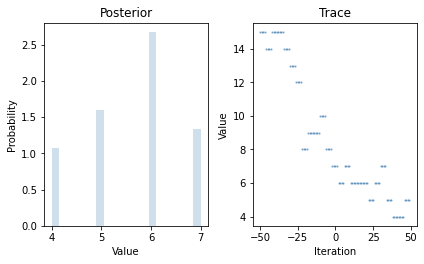

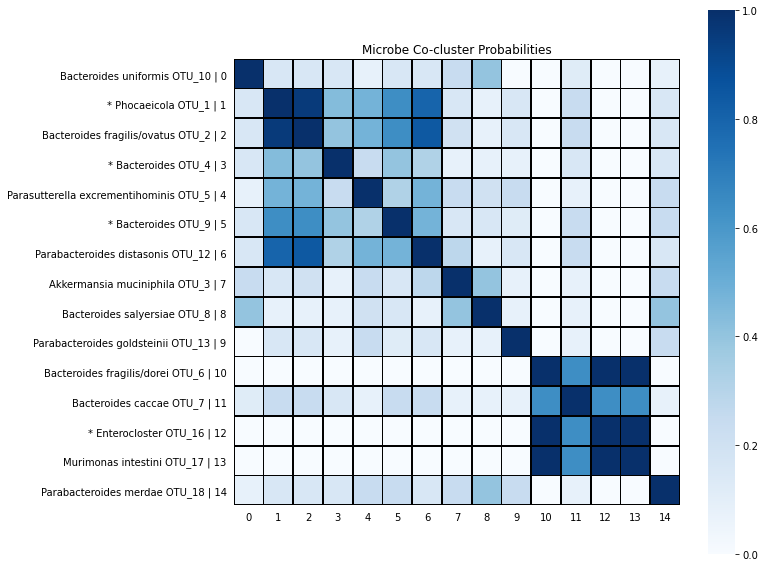

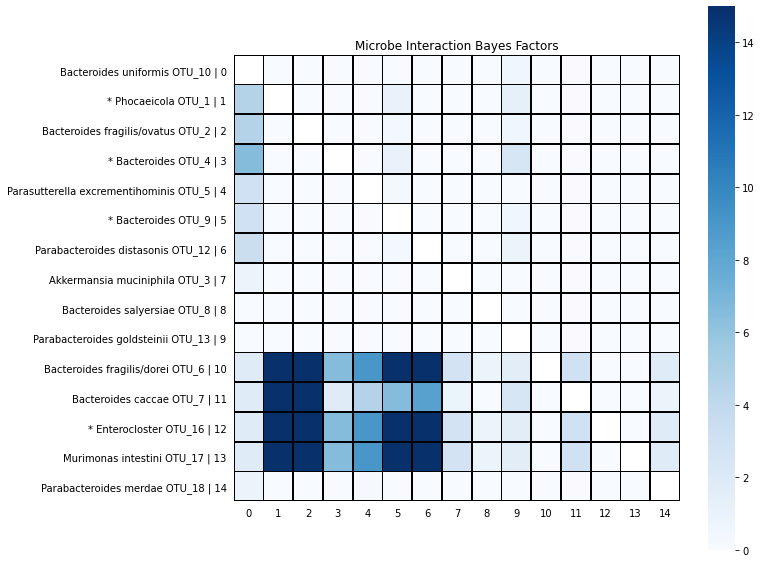

In [19]:
clustering = mcmc_uc1.graph[STRNAMES.CLUSTERING_OBJ]
md2.generate_cluster_assignments_posthoc(clustering, set_as_value=True)
taxa = mcmc_uc1.graph.data.taxa

md2.visualization.render_trace(clustering.n_clusters)
order = []
for i, cluster in enumerate(clustering):
    print('Cluster {}'.format(i))
    for oidx in cluster:
        print('\t', md2.taxaname_for_paper(taxa[oidx], taxa))
        order.append(oidx)

coclusters = md2.summary(mcmc_uc1.graph[STRNAMES.CLUSTERING_OBJ].coclusters)['mean']
md2.visualization.render_cocluster_probabilities(
    coclusters, taxa=uc_toy.taxa, yticklabels='%(paperformat)s | %(index)s',
    order=order)

bayes_factors = md2.generate_interation_bayes_factors_posthoc(mcmc_uc1)
md2.visualization.render_bayes_factors(
    bayes_factors, taxa=taxa, yticklabels='%(paperformat)s | %(index)s',
    order=order)

plt.show()

In [20]:
chains = [mcmc_uc0, mcmc_uc1]
start = 10
end = 20
vname = STRNAMES.GROWTH_VALUE

rhat = md2.pylab.inference.r_hat(chains, start=start, end=end, vname=vname)
print('Growth values:', rhat)

vname = STRNAMES.CONCENTRATION
rhat = md2.pylab.inference.r_hat(chains, start=start, end=end, vname=vname)
print('Concentration parameter:', rhat)

vname = STRNAMES.PROCESSVAR
rhat = md2.pylab.inference.r_hat(chains, start=start, end=end, vname=vname)
print('Process variance parameter:', rhat)


Growth values: [2.79181612 1.80527283 1.86420587 1.73146943 1.88098425 2.43759894 2.39621679 1.77152761 1.81584731 1.66314546 2.41326121 1.643547   1.76517458 2.15602453 2.1291014 ]
Concentration parameter: [1.41355116]
Process variance parameter: [3.47057399]


# Consensus clustering
Run the model with a fixed modules

In [21]:
# Use the clustering from a previous as the clustering assignment
params = md2.config.MDSINE2ModelConfig(
    basepath=basepath, seed=0, burnin=50, n_samples=100, 
    negbin_a0=a0, negbin_a1=a1, checkpoint=50)

# Do not learn the clustering parameters
params.LEARN[STRNAMES.CLUSTERING] = False
params.LEARN[STRNAMES.CONCENTRATION] = False

# Set the initialization option for clustering
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'fixed-clustering'
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value'] = 'output/mdsine2/uc100/mcmc.pkl'

mcmc = md2.initialize_graph(params=params, graph_name=uc_toy.name, subjset=uc_toy)
mcmc = md2.run_graph(mcmc, crash_if_error=True)

INFO:base.2534: max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
INFO:run.84: Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
INFO:run.251: There are 372 qPCR measurements for 3 buckets. Each bucket is 124 measurements long
INFO:run.286: Initializing Filtering
INFO:posterior.2659: Setting up the essential timepoints
INFO:posterior.2672: Essential timepoints: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.  11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.  37.5 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.  50.5 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.  60.5 61.  62.  63.  64.  64.5]
INFO:run.286: Initializing Zero inflation
INFO:design_matrices.847: Initializing LHS vector
INFO:design_matrices.1012: Initializing growth design matrix
INFO:design_matrices.940: Initializing self-inte

INFO:run.370: 		value: {100115: 0, 100116: 0, 100117: 0, 100118: 0, 100119: 0, 100120: 0}
INFO:run.371: 		prior.loc: 0
INFO:run.369: 	perturbation Vancomycin
INFO:run.370: 		value: {100115: 0, 100116: 0, 100117: 0, 100118: 0, 100119: 0, 100120: 0}
INFO:run.371: 		prior.loc: 0
INFO:run.369: 	perturbation Gentamicin
INFO:run.370: 		value: {100115: 0, 100116: 0, 100117: 0, 100118: 0, 100119: 0, 100120: 0}
INFO:run.371: 		prior.loc: 0
INFO:run.372: Perturbation prior variances:
INFO:run.374: 		dof: 2.5
INFO:run.375: 		scale: 2000.0
INFO:run.376: 		value: 10000.0
INFO:run.374: 		dof: 2.5
INFO:run.375: 		scale: 2000.0
INFO:run.376: 		value: 10000.0
INFO:run.374: 		dof: 2.5
INFO:run.375: 		scale: 2000.0
INFO:run.376: 		value: 10000.0
INFO:run.377: Perturbation indicators:
INFO:run.380: 	perturbation High Fat Diet: [False False False False False False]
INFO:run.380: 	perturbation Vancomycin: [False False False False False False]
INFO:run.380: 	perturbation Gentamicin: [False False False False 

INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.155360661555971, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.7886622384767377, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 1029.809047858009
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 720.3592907253241
	perturbation Vancomycin: 4153.79714908054
	perturbation Gentamicin: 1286.1432538180247
INFO:inference.439: Process Variance parameter: 4.4127939283057955, empirical_variance: 4.53606
INFO:inference.439: Filtering: parallel
INFO:inference.430: 

Inference iteration 2/100, time: 0.3300337791442871
INFO:inference.439: Cluster interaction indicator parameter: [False False False False  True False  True False False  True False Fa

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -2.281234289300041
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 90.00515438968306
	perturbation Vancomycin: -24.74531902339733
	perturbation Gentamicin: 52.03995799586877
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.6782313433235276, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.4289343302118171, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 25.19174953893933
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1118.4007662249455
	perturbation Vancomycin: 2326.798779791074
	perturbation Genta

INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.45014519 0.1676132  0.43651194 0.19413837 0.70460133 0.49387319 0.03311298 0.33241048 0.2310824  0.08654262 0.29044507 0.13660614 0.82240844 0.75962741 0.00224587]
Self Interactions:
[3.05483865e-01 2.50166326e-01 1.41834078e-01 1.41174142e+00 1.17706694e+00 1.90845836e-01 6.23009719e-02 3.94202296e-01 7.85859037e+01 3.79362400e+01 7.69764948e-01 3.07126045e+01 6.24769758e-01 3.32431913e+00 1.20996007e+00]
Interactions:
[-0.08081105 -9.17094629]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [ 6.4588896  -1.90015629  2.66547452]
	 perturbation Gentamicin: []
INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -18.370154496316896
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat 

INFO:inference.439: Cluster interaction probability: 0.03946922166871516
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.0060007572174072266s
perturbation High Fat Diet (0/6): [False False False False False False]
perturbation Vancomycin (1/6): [False False False  True False False]
perturbation Gentamicin (0/6): [False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.03878717051315371
	perturbation Vancomycin: 0.17393297241412647
	perturbation Gentamicin: 2.510913639594158e-05
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.79641692 0.36633103 0.47299227 0.4005884  0.57132962 0.249913   0.5583589  0.44972706 0.09374474 0.03798111 0.38098325 0.13054964 0.49518483 0.91484454 0.15995929]
Self Interactions:
[  0.43793895   0.22761304  

INFO:inference.439: Process Variance parameter: 4.294104936296857, empirical_variance: 4.19596
INFO:inference.439: Filtering: no-mp - Time: 0.2625, Acc: [0.618, 0.615, 0.601, 0.604, 0.610], data/sec: 21424.93
INFO:inference.430: 

Inference iteration 13/100, time: 0.29999780654907227
INFO:inference.439: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False]
total time: 0.013023614883422852, n_interactions: 1/30, 0.03
INFO:inference.439: Cluster interaction probability: 0.0026379229136257376
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.0049970149993896484s
perturbation High Fat Diet (0/6): [False False False False False False]
perturbation Vancomycin (1/6): [False False False  True False False]
perturbation Gentamicin (0/6): [False False False False False False]
INFO:inference.43

INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.5142654678261467, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.3904540765790463, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 298.65958579307966
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2062.1349334354413
	perturbation Vancomycin: 1631.9773148694414
	perturbation Gentamicin: 5087.800247674908
INFO:inference.439: Process Variance parameter: 4.084011294820449, empirical_variance: 4.04304
INFO:inference.439: Filtering: no-mp - Time: 0.2680, Acc: [0.627, 0.616, 0.637, 0.628, 0.594], data/sec: 20989.09
INFO:inference.430: 

Inference iteration 16/100, time: 0.29300975799560547
INFO:inference.439: Cluster interaction indicator p

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -8.678196361534376
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -47.995505671734115
	perturbation Vancomycin: 61.37269984256672
	perturbation Gentamicin: 92.85982475718455
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.953424770444821, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.4647010117085784, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 25.28571880732528
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 6838.066157540263
	perturbation Vancomycin: 1784.235811935288
	perturbation Gentam

INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.66649533 0.4037709  0.49525755 0.20725731 0.82221517 0.61520238 0.36766561 0.52715588 0.1825232  0.04184621 0.71640252 0.04138315 0.9333062  0.73882062 0.43906511]
Self Interactions:
[  0.42251889   0.20173396   0.21897366   3.41794671   1.38252241   0.22867407   0.64352526   1.72064851 121.629642   135.66981876   2.85475184  37.88612943   3.9570676    3.16097926   3.08496598]
Interactions:
[ -6.6771661  -19.59800899  -0.09575242   7.27029315 -10.79983976]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.35412568]
	 perturbation Gentamicin: [ -2.11252531 -23.20639367]
INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -6.892504621389872
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbatio

INFO:inference.439: Cluster interaction probability: 0.020192276274806423
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.006001949310302734s
perturbation High Fat Diet (1/6): [False False  True False False False]
perturbation Vancomycin (1/6): [False False False  True False False]
perturbation Gentamicin (1/6): [False  True False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.07289377081744602
	perturbation Vancomycin: 0.15065381334421196
	perturbation Gentamicin: 0.0949842837020094
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.66570868 0.43168677 0.51316651 0.01496783 0.67118231 0.74519208 0.57070088 0.53876468 0.14937818 0.09647773 0.73865872 0.07031098 1.03344154 0.79292514 0.37203777]
Self Interactions:
[  0.40929358   0.21310529   0.

INFO:inference.439: Process Variance parameter: 3.624769639500861, empirical_variance: 3.56364
INFO:inference.439: Filtering: no-mp - Time: 0.2530, Acc: [0.624, 0.608, 0.623, 0.619, 0.645], data/sec: 22236.20
INFO:inference.430: 

Inference iteration 27/100, time: 0.3211212158203125
INFO:inference.439: Cluster interaction indicator parameter: [False False False False  True False False False False False False False False False False  True False False False False False False False False False False False False False False]
total time: 0.01702404022216797, n_interactions: 2/30, 0.07
INFO:inference.439: Cluster interaction probability: 0.11680854629425952
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.007985591888427734s
perturbation High Fat Diet (0/6): [False False False False False False]
perturbation Vancomycin (2/6): [False False False  True False  True]
perturbation Gentamicin (1/6): [False  True False False False False]
INFO:inference.439: Pr

INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 3.6619467939499892, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.4375781130080918, Acceptance rate: 0.9655172413793104
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 728.6983451109502
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1459.168806243617
	perturbation Vancomycin: 3102.030297772815
	perturbation Gentamicin: 30683.230245108392
INFO:inference.439: Process Variance parameter: 3.4354653654093785, empirical_variance: 3.46254
INFO:inference.439: Filtering: no-mp - Time: 0.2550, Acc: [0.643, 0.628, 0.631, 0.612, 0.630], data/sec: 22061.74
INFO:inference.430: 

Inference iteration 30/100, time: 0.30315470695495605
INFO:inference.439: Cluster interacti

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -25.30430264195599
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 18.197900612329665
	perturbation Vancomycin: -38.59986609889202
	perturbation Gentamicin: 199.67868936289568
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 3.3635543005169413, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.5425149536160419, Acceptance rate: 0.96875
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 132.08989480325383
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1363.2197293985182
	perturbation Vancomycin: 1516.1092530795652
	perturbati

INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.43942546 0.55286414 0.4844741  0.16427796 0.8055127  0.43673083 0.59045751 0.28535183 0.27518368 0.04256303 0.56114054 0.25664032 1.00904865 0.93485578 0.45093191]
Self Interactions:
[  0.32215146   0.28390003   0.22634828   3.91184227   1.44453967   0.23280797   0.81871336   1.03480209 211.4976094  222.81400843   3.59743745  83.6152224    3.52669584   3.465485     5.84878581]
Interactions:
[-23.0106169   -0.09356941]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.54916485]
	 perturbation Gentamicin: []
INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -46.22033664630388
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -12.846355731854898
	perturbation Vancomycin: 5

INFO:inference.439: Cluster interaction probability: 0.18865630351735332
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.00899958610534668s
perturbation High Fat Diet (1/6): [False False False False False  True]
perturbation Vancomycin (1/6): [False False False  True False False]
perturbation Gentamicin (1/6): [False  True False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.19935624041667907
	perturbation Vancomycin: 0.1714397712607786
	perturbation Gentamicin: 0.285093641717238
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.60665546 0.46986081 0.41925193 0.24341601 0.64694046 0.4957476  0.72329305 0.51472063 0.35457749 0.18045513 0.39595504 0.22849731 1.29593541 0.90513626 0.31476353]
Self Interactions:
[3.81106405e-01 2.61460404e-01 1.86

INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 1936.588206681241
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2831.7633034864243
	perturbation Vancomycin: 991.7184603340052
	perturbation Gentamicin: 8073.793385081039
INFO:inference.439: Process Variance parameter: 3.0549016032764826, empirical_variance: 3.12731
INFO:inference.439: Filtering: no-mp - Time: 0.2640, Acc: [0.644, 0.621, 0.635, 0.621, 0.615], data/sec: 21309.34
INFO:inference.430: 

Inference iteration 41/100, time: 0.29999828338623047
INFO:inference.439: Cluster interaction indicator parameter: [False False False False  True False False False False False False False False False False  True False False False False False False False False False False False  True False False]
total time: 0.013023853302001953, n_interactions: 3/30, 0.10
INFO:inference.439: Cluster interact

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -17.527688721443774
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -147.3340104395492
	perturbation Vancomycin: 47.893769482096765
	perturbation Gentamicin: 43.39363855276887
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.591133095109948, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.38958645071441794, Acceptance rate: 0.9767441860465116
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 967.9662386896958
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1271.1904174446195
	perturbation Vancomycin: 13437.909825490171
	

INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.3794701  0.65140627 0.37315146 0.18036816 0.71789518 1.07994346 0.69392289 0.41204211 0.0794063  0.09472997 0.60210113 0.21342636 1.40337581 1.1408622  0.48132077]
Self Interactions:
[2.35406233e-01 3.38695647e-01 2.28003275e-01 1.15548312e+01 1.22003678e+00 5.92044901e-01 1.37070678e-01 1.71533716e+00 2.34439134e+02 2.09103010e+02 2.64446127e+00 9.13972948e+01 3.06475930e+00 2.05966619e+00 4.99884869e+00]
Interactions:
[-35.60952923  -0.15507544]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.07006326]
	 perturbation Gentamicin: [-2.05598708 -0.49728133]
INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -43.38924641357204
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat 

INFO:inference.439: Cluster interaction probability: 0.08808463218238503
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.006999969482421875s
perturbation High Fat Diet (0/6): [False False False False False False]
perturbation Vancomycin (1/6): [False False False  True False False]
perturbation Gentamicin (1/6): [False  True False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.004948924408679488
	perturbation Vancomycin: 0.26618810067703125
	perturbation Gentamicin: 0.2051392097682458
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.70016531 0.36591961 0.80179924 0.07187001 0.83343297 0.66868946 0.65704213 0.57341526 0.29263975 0.04782842 0.7161317  0.27381666 1.14439101 1.2468584  0.22532313]
Self Interactions:
[  0.39510799   0.30512462   0.

INFO:inference.439: Process Variance parameter: 2.756114261070976, empirical_variance: 2.80460
INFO:inference.439: Filtering: no-mp - Time: 0.2570, Acc: [0.628, 0.609, 0.609, 0.613, 0.621], data/sec: 21888.24
INFO:inference.430: 

Inference iteration 52/100, time: 0.32111406326293945
INFO:inference.439: Cluster interaction indicator parameter: [False False False False  True False False False False False False False False False False  True False False False False False False False False  True False False False False False]
total time: 0.016022443771362305, n_interactions: 3/30, 0.10
INFO:inference.439: Cluster interaction probability: 0.06123171290005596
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.00797414779663086s
perturbation High Fat Diet (0/6): [False False False False False False]
perturbation Vancomycin (1/6): [False False False  True False False]
perturbation Gentamicin (1/6): [False  True False False False False]
INFO:inference.439: P

INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.4603597704613775, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.4977638099230629, Acceptance rate: 0.98
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 595.9090979454378
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 32570.761166035325
	perturbation Vancomycin: 3004.1045035429784
	perturbation Gentamicin: 4412.162758754311
INFO:inference.439: Process Variance parameter: 2.722106633791945, empirical_variance: 2.68213
INFO:inference.439: Filtering: no-mp - Time: 0.3020, Acc: [0.618, 0.591, 0.620, 0.657, 0.598], data/sec: 18623.83
INFO:inference.430: 

Inference iteration 55/100, time: 0.3060765266418457
INFO:inference.439: Cluster interaction indicator pa

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -50.447393406437854
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 29.2870729258955
	perturbation Vancomycin: -25.70372256152452
	perturbation Gentamicin: 62.40488632388736
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.7240280171519333, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.5343739565319863, Acceptance rate: 0.98
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 2863.624680248692
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3420.515756409465
	perturbation Vancomycin: 2922.356528055812
	perturbation Genta

INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.89443077 0.65042348 0.90435516 0.10958642 0.82169126 0.53969344 0.61854785 0.56976239 0.10536085 0.27519288 0.43844276 0.22455593 1.35469471 0.88120079 0.67190289]
Self Interactions:
[  0.51917641   0.31293893   0.25157069   9.13902683   1.181861     0.37541236   0.84963349   1.69663894 104.73067263 229.40542261   2.17432024  67.81846698   3.3845898    2.29455256   5.0513897 ]
Interactions:
[-55.53155139  -0.16593123]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.23176417]
	 perturbation Gentamicin: [-1.6664077]
INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -10.352874953153552
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -48.41737211856953
	perturbation Van

INFO:inference.439: Cluster interaction probability: 0.02529425940754236
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.007001161575317383s
perturbation High Fat Diet (0/6): [False False False False False False]
perturbation Vancomycin (1/6): [False False False  True False False]
perturbation Gentamicin (1/6): [False  True False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.05075347413465875
	perturbation Vancomycin: 0.11195268282871121
	perturbation Gentamicin: 0.24425076844097207
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.50796215 0.43205983 0.71250909 0.30044021 0.62259903 0.66701338 0.57541747 0.47798887 0.25327524 0.04901171 0.54672666 0.19955797 1.07064128 1.11428307 0.46390064]
Self Interactions:
[3.63827623e-01 1.80194407e-01 

INFO:inference.439: Process Variance parameter: 2.6048075625033382, empirical_variance: 2.54897
INFO:inference.439: Filtering: no-mp - Time: 0.2775, Acc: [0.639, 0.627, 0.623, 0.618, 0.618], data/sec: 20270.89
INFO:inference.430: 

Inference iteration 66/100, time: 0.3385143280029297
INFO:inference.439: Cluster interaction indicator parameter: [False False False False  True False False False False False False False False False False  True False False False False False False False False  True False False False False False]
total time: 0.01685643196105957, n_interactions: 3/30, 0.10
INFO:inference.439: Cluster interaction probability: 0.1388016252753313
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.009191036224365234s
perturbation High Fat Diet (0/6): [False False False False False False]
perturbation Vancomycin (1/6): [False False False  True False False]
perturbation Gentamicin (2/6): [False  True False False False  True]
INFO:inference.439: Pr

INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.416957874916155, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.0752996983809808, Acceptance rate: 0.98
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 475.1706931588946
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1307.3337198242589
	perturbation Vancomycin: 1156.3316252003767
	perturbation Gentamicin: 2835.340701292766
INFO:inference.439: Process Variance parameter: 2.5103790260211922, empirical_variance: 2.52444
INFO:inference.439: Filtering: no-mp - Time: 0.2729, Acc: [0.620, 0.606, 0.628, 0.629, 0.617], data/sec: 20612.95
INFO:inference.430: 

Inference iteration 69/100, time: 0.324535608291626
INFO:inference.439: Cluster interaction indicator par

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -15.005015548737376
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 33.82050972019949
	perturbation Vancomycin: -29.794806830697052
	perturbation Gentamicin: -17.263423067692575
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.3245345513589004, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.1284584063242683, Acceptance rate: 0.98
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 3948.7510790090773
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1203.952050355209
	perturbation Vancomycin: 1686.194262382277
	perturbation 

INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.72703305 0.47882417 0.83918306 0.27117957 0.73634815 0.4997949  0.61319083 0.68987179 0.52188745 0.14102346 0.78139581 0.06579736 1.27304836 0.92739361 0.44466926]
Self Interactions:
[3.89933426e-01 2.88622656e-01 2.40096943e-01 7.29321100e+00 1.20520911e+00 3.62407534e-01 3.73272042e-01 1.88492411e+00 1.87811114e+02 2.66769863e+02 3.40063486e+00 1.02461416e+02 3.31857828e+00 4.66568318e+00 4.00147422e+00]
Interactions:
[-81.8807369   -0.13862359]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.30796739]
	 perturbation Gentamicin: [-1.35016145 -5.40691853]
INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -7.310247051503616
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat 

INFO:inference.439: Cluster interaction probability: 0.056560739419510994
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.007005929946899414s
perturbation High Fat Diet (0/6): [False False False False False False]
perturbation Vancomycin (1/6): [False False False  True False False]
perturbation Gentamicin (1/6): [False  True False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0008313080232564864
	perturbation Vancomycin: 0.25465416807724855
	perturbation Gentamicin: 0.46882476099010584
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.52428618 0.52437588 0.63379628 0.07797971 0.60154314 0.57371239 0.56817137 0.48738505 0.27206301 0.15858008 0.64950545 0.18110972 1.19192837 1.03815031 0.35930169]
Self Interactions:
[4.21631167e-01 2.38488886e-

INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 8117.184611686882
	perturbation Vancomycin: 3181.148190530175
	perturbation Gentamicin: 12367.749389414308
INFO:inference.439: Process Variance parameter: 2.472485612914943, empirical_variance: 2.39999
INFO:inference.439: Filtering: no-mp - Time: 0.2670, Acc: [0.620, 0.616, 0.613, 0.628, 0.628], data/sec: 21064.73
INFO:inference.430: 

Inference iteration 80/100, time: 0.3040294647216797
INFO:inference.439: Cluster interaction indicator parameter: [False False False False  True False False False False False False False False False False  True False False False False False False False False False False False False False False]
total time: 0.017000913619995117, n_interactions: 2/30, 0.07
INFO:inference.439: Cluster interaction probability: 0.04311833682161577
INFO:inference.439: Perturbation indicator parameter: Perturbation Indica

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -26.69349804917513
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 73.67623043558721
	perturbation Vancomycin: 3.8558337209968663
	perturbation Gentamicin: -31.78509867201335
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.721245990401372, Acceptance rate: 0.98
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.935625160852444, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 735.2571122943483
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3639.3606397363324
	perturbation Vancomycin: 2864.6002247768547
	perturbation Gent

INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.64142776 0.25621831 0.72620643 0.0785961  0.53026367 0.81687457 0.55533485 0.52416436 0.33250394 0.03042779 0.69551513 0.28824082 0.88506095 0.99456754 0.32093877]
Self Interactions:
[3.19332099e-01 2.05010027e-01 2.78267331e-01 5.53285843e+00 1.01682487e+00 4.17294405e-01 5.18250349e-01 1.37235481e+00 1.32151703e+02 2.41872679e+02 2.54008167e+00 1.20913969e+02 1.32317918e+00 3.64443637e+00 4.93088360e+00]
Interactions:
[-60.76442861  -0.14884993 -16.47522763]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.35506769]
	 perturbation Gentamicin: [ -2.27249322 -16.66480728]
INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -22.66336496967953
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturb

INFO:inference.439: Cluster interaction probability: 0.04062205443385854
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.007001161575317383s
perturbation High Fat Diet (0/6): [False False False False False False]
perturbation Vancomycin (1/6): [False False False  True False False]
perturbation Gentamicin (1/6): [False  True False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.10775809767684025
	perturbation Vancomycin: 0.1472139434031693
	perturbation Gentamicin: 0.09264461756345957
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.53571998 0.35011774 0.50861022 0.20578921 0.77081745 0.70702033 0.61500142 0.4765268  0.27038345 0.23489552 0.75395176 0.20688964 0.81021099 1.1057814  0.27479975]
Self Interactions:
[3.49164729e-01 1.89618951e-01 1

INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 836.1515233994068
	perturbation Vancomycin: 3033.723364117417
	perturbation Gentamicin: 2087.3747550869975
INFO:inference.439: Process Variance parameter: 2.285800405691673, empirical_variance: 2.26209
INFO:inference.439: Filtering: no-mp - Time: 0.2590, Acc: [0.630, 0.612, 0.627, 0.592, 0.581], data/sec: 21720.94
INFO:inference.430: 

Inference iteration 91/100, time: 0.30510711669921875
INFO:inference.439: Cluster interaction indicator parameter: [False False False False  True False False False False False False False False False False  True False False False False False False False False False False False False False False]
total time: 0.015031576156616211, n_interactions: 2/30, 0.07
INFO:inference.439: Cluster interaction probability: 0.026621405700876836
INFO:inference.439: Perturbation indicator parameter: Perturbation Indi

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -21.56014479471327
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -47.00874422809066
	perturbation Vancomycin: 106.45323518502012
	perturbation Gentamicin: -90.3201706345511
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.8199269520346784, Acceptance rate: 0.98
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.115991842543891, Acceptance rate: 0.94
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 510.11888217847553
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2731.9921071894096
	perturbation Vancomycin: 7571.913421395765
	perturbation Ge

INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.80980821 0.39335371 0.59415616 0.1170087  0.67546495 0.74991077 0.57828418 0.57510366 0.48421558 0.06962755 0.55955805 0.28396644 0.95013786 1.0010836  0.36800512]
Self Interactions:
[  0.45453438   0.21689297   0.26513027   5.10477294   1.25951313   0.46243098   0.71353851   0.95657814 197.50863117 196.65886946   2.68139946 149.45716182   2.50707659   3.50517178   5.64445877]
Interactions:
[-90.99489449  -0.13473467]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.29184332]
	 perturbation Gentamicin: [-2.22021019]
INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 25.93763890556899
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -33.41830563897554
	perturbation Vanc

INFO:inference.439: Cluster interaction probability: 0.14207258834815173
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.007006168365478516s
perturbation High Fat Diet (0/6): [False False False False False False]
perturbation Vancomycin (1/6): [False False False  True False False]
perturbation Gentamicin (1/6): [False  True False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0018409790119152914
	perturbation Vancomycin: 0.3784684791848555
	perturbation Gentamicin: 0.33481470817986014
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.68561181 0.47837225 0.49846221 0.10006768 0.67497543 0.76470943 0.61320951 0.44483539 0.07585762 0.10043855 0.59920901 0.35008443 0.99026174 0.89225539 0.33156973]
Self Interactions:
[4.50387447e-01 2.49269116e-01

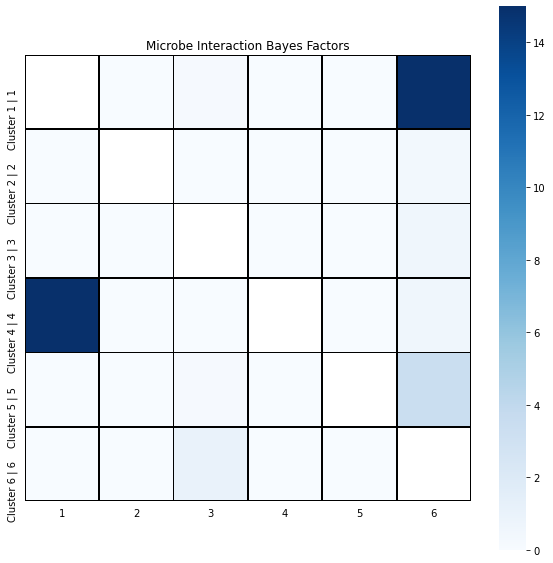

In [23]:
# Plot the posterior
clustering = mcmc.graph[STRNAMES.CLUSTERING_OBJ]
bf_taxa = md2.generate_interation_bayes_factors_posthoc(mcmc)
bf_clustering = md2.condense_fixed_clustering_interaction_matrix(bf_taxa, clustering=clustering)

labels = ['Cluster {} | {}'.format(i+1, i+1) for i in range(len(clustering))]
md2.visualization.render_bayes_factors(bf_clustering, yticklabels=labels)
plt.show()

# Cross validation

Take out a single subject and use that as initial conditions for forward simulation

In [24]:
# Make the data and validation Study objects
study = md2.dataset.parse(
    name='uc-toy-dataset', 
    taxonomy='data/uc-toy/taxonomy.tsv', 
    reads='data/uc-toy/reads.tsv', 
    qpcr='data/uc-toy/qpcr.tsv', 
    perturbations='data/uc-toy/perturbations.tsv', 
    metadata='data/uc-toy/metadata.tsv')

val = study.pop_subject('8')
val.name += '-validate'

print(study.name)
for subj in study:
    print(subj.name)
for pert in study.perturbations:
    print(pert)
print()
print(val.name)
for subj in val:
    print(subj.name)
for pert in val.perturbations:
    print(pert)


INFO:base.1117: TaxaSet parsng new taxonomy table. Resetting


uc-toy-dataset
10
6
7
9
Perturbation High Fat Diet:
	Subject 6: (21.5, 28.5)
	Subject 7: (21.5, 28.5)
	Subject 9: (21.5, 28.5)
	Subject 10: (21.5, 28.5)

Perturbation Vancomycin:
	Subject 6: (35.5, 42.5)
	Subject 7: (35.5, 42.5)
	Subject 9: (35.5, 42.5)
	Subject 10: (35.5, 42.5)

Perturbation Gentamicin:
	Subject 6: (50.5, 57.5)
	Subject 7: (50.5, 57.5)
	Subject 9: (50.5, 57.5)
	Subject 10: (50.5, 57.5)


unnamed-study-validate
8
Perturbation High Fat Diet:
	Subject 8: (21.5, 28.5)

Perturbation Vancomycin:
	Subject 8: (35.5, 42.5)

Perturbation Gentamicin:
	Subject 8: (50.5, 57.5)



In [25]:
# Learn the model
params = md2.config.MDSINE2ModelConfig(
    basepath='output/mdsine2/cv/'+study.name, seed=0, 
    burnin=50, n_samples=100, 
    negbin_a0=a0, negbin_a1=a1, checkpoint=50)
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'
mcmc = md2.initialize_graph(params=params, graph_name=study.name, subjset=study)
mcmc = md2.run_graph(mcmc, crash_if_error=True)

INFO:base.2534: max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
INFO:run.84: Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
INFO:run.251: There are 297 qPCR measurements for 3 buckets. Each bucket is 99 measurements long
INFO:run.286: Initializing Filtering
INFO:posterior.2659: Setting up the essential timepoints
INFO:posterior.2672: Essential timepoints: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.  11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.  37.5 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.  50.5 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.  60.5 61.  62.  63.  64.  64.5]
INFO:run.286: Initializing Zero inflation
INFO:design_matrices.847: Initializing LHS vector
INFO:design_matrices.1012: Initializing growth design matrix
INFO:design_matrices.940: Initializing self-inter

INFO:run.371: 		prior.loc: 0
INFO:run.369: 	perturbation Vancomycin
INFO:run.370: 		value: {100115: 0, 100116: 0, 100117: 0, 100118: 0, 100119: 0, 100120: 0, 100121: 0, 100122: 0, 100123: 0, 100124: 0, 100125: 0, 100126: 0, 100127: 0, 100128: 0, 100129: 0}
INFO:run.371: 		prior.loc: 0
INFO:run.369: 	perturbation Gentamicin
INFO:run.370: 		value: {100115: 0, 100116: 0, 100117: 0, 100118: 0, 100119: 0, 100120: 0, 100121: 0, 100122: 0, 100123: 0, 100124: 0, 100125: 0, 100126: 0, 100127: 0, 100128: 0, 100129: 0}
INFO:run.371: 		prior.loc: 0
INFO:run.372: Perturbation prior variances:
INFO:run.374: 		dof: 2.5
INFO:run.375: 		scale: 2000.0
INFO:run.376: 		value: 10000.0
INFO:run.374: 		dof: 2.5
INFO:run.375: 		scale: 2000.0
INFO:run.376: 		value: 10000.0
INFO:run.374: 		dof: 2.5
INFO:run.375: 		scale: 2000.0
INFO:run.376: 		value: 10000.0
INFO:run.377: Perturbation indicators:
INFO:run.380: 	perturbation High Fat Diet: [False False False False False False False False False False False False 

INFO:inference.439: Cluster interaction probability: 0.5907630856509913
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.022998571395874023s
perturbation High Fat Diet (9/15): [False  True False  True  True False  True  True  True  True False  True  True False False]
perturbation Vancomycin (10/15): [False  True False  True  True  True  True False  True False  True False  True  True  True]
perturbation Gentamicin (11/15): [False  True  True False  True  True False  True False  True  True  True  True  True  True]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.5032813527614807
	perturbation Vancomycin: 0.606532764595715
	perturbation Gentamicin: 0.65283684507178
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.16729313 0.38474118 0.65715856 0.37039815 0.60867957 0

INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.10972506 0.21148443 0.43925925 0.34365468 0.67488577 0.70132305 0.28162154 0.30065323 0.29477391 0.29784929 0.33265642 0.45148658 1.44128478 0.78970728 0.06458668]
Self Interactions:
[1.32745348e-01 1.23881716e-01 1.78659679e-01 5.65656439e-01 1.17473680e+00 1.03254784e+00 4.13167191e-02 6.53079735e-01 3.72199788e+01 8.73839888e+01 3.22004535e-01 8.53225905e+01 3.68086562e+00 1.39783576e+00 1.65678417e+00]
Interactions:
[-77.49646579  67.48763089   5.15166016   0.57347955   3.37905664 -44.02942331   0.11516085  49.23850219  -6.09884891 -30.41495227 -54.69767729  -1.68261957  10.86261459   0.29298456  -2.09105291  28.21435316  -1.30003362  23.36454725  -3.20815841 -16.97049929 -45.63522185   3.62333115 -43.06296863 -18.94839314  -3.82427379 -21.95339478  14.28409504  67.11968828  -2.19732424   9.90394752   8.9801119    2.29255911  55.01367056 -30.35258535  -1.59735015 -55.3

INFO:inference.439: Clustering concentration parameter: 1028.3260132447924
INFO:inference.430: 

Inference iteration 4/100, time: 0.31998586654663086
INFO:inference.439: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fa

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -59.56548232362257
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 112.77836301278023
	perturbation Vancomycin: 43.758547237931694
	perturbation Gentamicin: 103.29891945199456
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.8426204778425026, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.07471409926827421, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 347.43075185696097
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 821.7305222884659
	perturbation Vancomycin: 1836.3085429804175
	perturbation G

INFO:inference.439: Cluster interaction probability: 0.0018577960620059617
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.012033224105834961s
perturbation High Fat Diet (2/15): [False False False False False  True False False  True False False False False False False]
perturbation Vancomycin (3/15): [False False False False False False  True  True False False False False False False  True]
perturbation Gentamicin (0/15): [False False False False False False False False False False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.1086956386411362
	perturbation Vancomycin: 0.0897347436348209
	perturbation Gentamicin: 0.03532776678325556
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.50037082 0.52311915 0.20572461 0.15906428 0.37729

INFO:inference.439: Clustering concentration parameter: 140.9078225950882
INFO:posterior.1580: 0/15: 2
INFO:posterior.1580: 1/15: 7
INFO:posterior.1580: 2/15: 3
INFO:posterior.1580: 3/15: 6
INFO:posterior.1580: 4/15: 1
INFO:posterior.1580: 5/15: 13
INFO:posterior.1580: 6/15: 8
INFO:posterior.1580: 7/15: 0
INFO:posterior.1580: 8/15: 5
INFO:posterior.1580: 9/15: 4
INFO:posterior.1580: 10/15: 14
INFO:posterior.1580: 11/15: 9
INFO:posterior.1580: 12/15: 10
INFO:posterior.1580: 13/15: 11
INFO:posterior.1580: 14/15: 12
INFO:inference.430: 

Inference iteration 9/100, time: 0.784398078918457
INFO:inference.439: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fals

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -66.69836082858919
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -18.680954083890892
	perturbation Vancomycin: -36.24568792925337
	perturbation Gentamicin: 50.46942130462113
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.44010924033125, Acceptance rate: 0.9
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.5799708116413829, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 15287.743242553692
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2261.321099367641
	perturbation Vancomycin: 2229.1558002775573
	perturbation Gent

INFO:inference.439: Cluster interaction probability: 5.139356877196297e-06
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.009000062942504883s
perturbation High Fat Diet (0/14): [False False False False False False False False False False False False False False]
perturbation Vancomycin (2/14): [ True False False False False False False False False False False False False  True]
perturbation Gentamicin (0/14): [False False False False False False False False False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.004181017733358052
	perturbation Vancomycin: 0.05229926968925037
	perturbation Gentamicin: 0.024957161353312243
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[3.64942575e-01 1.87921592e-01 4.57791909e-01 1.37876159e-01 4.845

INFO:inference.439: Clustering concentration parameter: 221.04826133462552
INFO:inference.430: 

Inference iteration 14/100, time: 0.2881588935852051
INFO:inference.439: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fa

INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.3896674808254445, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 23.320637164415075
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1158.5997931837164
	perturbation Vancomycin: 1562.16577986991
	perturbation Gentamicin: 7435.378249632983
INFO:inference.439: Process Variance parameter: 4.285908756811641, empirical_variance: 4.22219
INFO:inference.439: Filtering: no-mp - Time: 0.1970, Acc: [0.628, 0.598, 0.630, 0.580], data/sec: 22842.66
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 14
Cluster 100142
	members: ['OTU_17', 'OTU_16']
	size: 2
Cluster 100179
	members: ['OTU_7']
	size: 1
Cluster 100181
	members: ['OTU_12']
	size: 1
Cl

INFO:inference.439: Cluster interaction probability: 0.004598881086415299
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.009992599487304688s
perturbation High Fat Diet (0/13): [False False False False False False False False False False False False False]
perturbation Vancomycin (1/13): [ True False False False False False False False False False False False False]
perturbation Gentamicin (5/13): [False  True False False False False  True  True False False  True False  True]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0001679027614001275
	perturbation Vancomycin: 0.040940989041821405
	perturbation Gentamicin: 0.20483779375635303
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.38033333 0.35569969 0.38185614 0.20910586 0.55989372 0.06098593 0.43357001 0.2411

INFO:inference.439: Clustering concentration parameter: 46.61425751118004
INFO:inference.430: 

Inference iteration 19/100, time: 0.2990000247955322
INFO:inference.439: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fal

INFO:inference.439: Process Variance parameter: 4.107048738486157, empirical_variance: 4.04335
INFO:inference.439: Filtering: no-mp - Time: 0.2060, Acc: [0.642, 0.606, 0.628, 0.588], data/sec: 21844.78
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 13
Cluster 100142
	members: ['OTU_17', 'OTU_16']
	size: 2
Cluster 100205
	members: ['OTU_6']
	size: 1
Cluster 100207
	members: ['OTU_4']
	size: 1
Cluster 100209
	members: ['OTU_8', 'OTU_1']
	size: 2
Cluster 100211
	members: ['OTU_2']
	size: 1
Cluster 100212
	members: ['OTU_3']
	size: 1
Cluster 100214
	members: ['OTU_18']
	size: 1
Cluster 100216
	members: ['OTU_12']
	size: 1
Cluster 100217
	members: ['OTU_5']
	size: 1
Cluster 100219
	members: ['OTU_9']
	size: 1
Cluster 100220
	members: ['OTU_10']
	size: 1
Cluster 100221
	members: ['OTU_7']
	size: 1
Cluster 100223
	members: ['OTU_13']
	size: 1
no mp - Total time: 0.5120000839233398
INFO:inference.439: Clustering con

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -63.610401871792334
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 45.21295744058356
	perturbation Vancomycin: 9.276531382226093
	perturbation Gentamicin: 199.78078363153242
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.7123593829908097, Acceptance rate: 0.9545454545454546
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.6435142506703988, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 12.201636080776309
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 911.6287019854049
	perturbation Vancomycin: 1548.778588775074
	pe

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -67.180295123218
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -65.7971279085503
	perturbation Vancomycin: -18.553244907858314
	perturbation Gentamicin: 266.3323217657001
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.9141338898020208, Acceptance rate: 0.9583333333333334
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.9009530891351063, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 29.177149308677006
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4139.500462513428
	perturbation Vancomycin: 12088.159400701885
	per

INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -19.99916245963523
	perturbation Vancomycin: 9.82944675707833
	perturbation Gentamicin: -131.28380805563688
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.005938399508572, Acceptance rate: 0.9615384615384616
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.9322822751797336, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 72.76751813511395
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 18851.84769746613
	perturbation Vancomycin: 9107.518528073839
	perturbation Gentamicin: 4707.213494069438
INFO:inference.439: Process Variance parameter: 3.6933362415233337

INFO:inference.439: Clustering concentration parameter: 1.1739333826070526
INFO:posterior.1580: 0/15: 12
INFO:posterior.1580: 1/15: 6
INFO:posterior.1580: 2/15: 14
INFO:posterior.1580: 3/15: 11
INFO:posterior.1580: 4/15: 10
INFO:posterior.1580: 5/15: 5
INFO:posterior.1580: 6/15: 4
INFO:posterior.1580: 7/15: 0
INFO:posterior.1580: 8/15: 9
INFO:posterior.1580: 9/15: 3
INFO:posterior.1580: 10/15: 13
INFO:posterior.1580: 11/15: 8
INFO:posterior.1580: 12/15: 1
INFO:posterior.1580: 13/15: 7
INFO:posterior.1580: 14/15: 2
INFO:inference.430: 

Inference iteration 29/100, time: 0.4160428047180176
INFO:inference.439: Cluster interaction indicator parameter: [False False False  True False False False False False False False False False False False False False False False False]
total time: 0.012999773025512695, n_interactions: 1/20, 0.05
INFO:inference.439: Cluster interaction probability: 0.04944712178141945
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 4.293542558625438
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 85.4920476556734
	perturbation Vancomycin: -12.79337156349073
	perturbation Gentamicin: -152.7660850097066
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.33936946641199295, Acceptance rate: 0.967741935483871
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.067994989868025, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 75.568792763055
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 713.0045162727514
	perturbation Vancomycin: 1001.0227494082985
	perturb

INFO:inference.439: Process Variance parameter: 3.5812654142730422, empirical_variance: 3.64904
INFO:inference.439: Filtering: no-mp - Time: 0.2170, Acc: [0.610, 0.602, 0.622, 0.638], data/sec: 20737.28
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 3
Cluster 100142
	members: ['OTU_16', 'OTU_17', 'OTU_6']
	size: 3
Cluster 100233
	members: ['OTU_10', 'OTU_1', 'OTU_9', 'OTU_3', 'OTU_7', 'OTU_5', 'OTU_2']
	size: 7
Cluster 100247
	members: ['OTU_13', 'OTU_8', 'OTU_12', 'OTU_18', 'OTU_4']
	size: 5
no mp - Total time: 0.15796709060668945
INFO:inference.439: Clustering concentration parameter: 0.6903439427203601
INFO:inference.430: 

Inference iteration 34/100, time: 0.2479860782623291
INFO:inference.439: Cluster interaction indicator parameter: [False  True False False False False]
total time: 0.0060002803802490234, n_interactions: 1/6, 0.17
INFO:inference.439: Cluster interaction probability: 0.04278349937089688


INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 0.8944008275840205
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -15.017600206583777
	perturbation Vancomycin: 13.093165059237492
	perturbation Gentamicin: 7.141920641381623
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.2753464309666026, Acceptance rate: 0.9444444444444444
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.84942258196867, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 43.00924211122506
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1114.7775645353208
	perturbation Vancomycin: 664.5368780838406
	per

INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 3
Cluster 100142
	members: ['OTU_6', 'OTU_16', 'OTU_17']
	size: 3
Cluster 100233
	members: ['OTU_13', 'OTU_10', 'OTU_18', 'OTU_5', 'OTU_3', 'OTU_9', 'OTU_1', 'OTU_4', 'OTU_2', 'OTU_7']
	size: 10
Cluster 100247
	members: ['OTU_8', 'OTU_12']
	size: 2
no mp - Total time: 0.1389789581298828
INFO:inference.439: Clustering concentration parameter: 0.6064530200450489
INFO:inference.430: 

Inference iteration 39/100, time: 0.2440330982208252
INFO:inference.439: Cluster interaction indicator parameter: [False  True  True  True False False]
total time: 0.007988214492797852, n_interactions: 3/6, 0.50
INFO:inference.439: Cluster interaction probability: 0.2846624590200069
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.0040357112884521484s
perturbation High Fat Diet (0/3): [False False False]
perturbation Vancomycin (1/3): [ True Fals

INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.59523046 0.40125156 0.52325553 0.13344844 0.417001   0.64369978 0.3586943  0.39442344 0.24521432 0.22415863 0.3975783  0.3556103  0.91623545 1.02011299 0.44639504]
Self Interactions:
[4.36153611e-01 1.95469816e-01 2.56936589e-01 6.95984541e+00 8.08630183e-01 4.92851638e-01 9.72995192e-01 1.47107986e+00 1.21663187e+02 2.45801923e+02 2.53672325e+00 1.03791073e+02 2.72942663e+00 4.27186708e+00 5.94046173e+00]
Interactions:
[-0.87342155  0.29558395 -0.28730608]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.38515336]
	 perturbation Gentamicin: []
INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -5.12775592231597
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 83.95200

INFO:inference.439: Process Variance parameter: 3.2358782849590866, empirical_variance: 3.22917
INFO:inference.439: Filtering: no-mp - Time: 0.1970, Acc: [0.611, 0.631, 0.613, 0.630], data/sec: 22842.75
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 3
Cluster 100142
	members: ['OTU_7', 'OTU_17', 'OTU_6', 'OTU_16']
	size: 4
Cluster 100233
	members: ['OTU_13', 'OTU_2', 'OTU_10', 'OTU_18', 'OTU_3', 'OTU_5', 'OTU_1', 'OTU_9', 'OTU_4']
	size: 9
Cluster 100247
	members: ['OTU_8', 'OTU_12']
	size: 2
no mp - Total time: 0.1680004596710205
INFO:inference.439: Clustering concentration parameter: 0.5341214537088945
INFO:inference.430: 

Inference iteration 44/100, time: 0.24457812309265137
INFO:inference.439: Cluster interaction indicator parameter: [False  True  True  True False False]
total time: 0.00799870491027832, n_interactions: 3/6, 0.50
INFO:inference.439: Cluster interaction probability: 0.4408383257419711
INF

INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.013097212428563959
	perturbation Vancomycin: 0.44607101732917565
	perturbation Gentamicin: 0.06380201264963353
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.63971226 0.35715413 0.4549466  0.10070421 0.51605066 0.38154058 0.4587878  0.44812758 0.27148956 0.07526801 0.55516781 0.12673188 0.8364275  0.77228697 0.60100313]
Self Interactions:
[3.82003570e-01 1.52981782e-01 2.56911826e-01 5.84979623e+00 7.67246998e-01 3.82076108e-01 6.05483541e-03 1.35984594e+00 1.29688318e+02 2.53590310e+02 2.40701320e+00 8.13920509e+01 1.79425379e+00 2.75904234e+00 5.08786683e+00]
Interactions:
[-1.93668622  0.23516969 -1.15341505]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.44301788]
	 perturbati

INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 13.9999884485317
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2270.412620522459
	perturbation Vancomycin: 1815.052394036401
	perturbation Gentamicin: 4554.502952002952
INFO:inference.439: Process Variance parameter: 3.1784172079118505, empirical_variance: 3.05748
INFO:inference.439: Filtering: no-mp - Time: 0.2030, Acc: [0.619, 0.604, 0.598, 0.629], data/sec: 22167.43
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 3
Cluster 100142
	members: ['OTU_7', 'OTU_17', 'OTU_6', 'OTU_16']
	size: 4
Cluster 100233
	members: ['OTU_2', 'OTU_1', 'OTU_18', 'OTU_3', 'OTU_5', 'OTU_9', 'OTU_4', 'OTU_8', 'OTU_10']
	size: 9
Cluster 100247
	members: ['OTU_12', 'OTU_13']
	size: 2
no mp - Total time: 0.15001320838928223
INFO:infere

INFO:inference.439: Cluster interaction probability: 0.24545657830737486
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.00698399543762207s
perturbation High Fat Diet (0/3): [False False False]
perturbation Vancomycin (1/3): [ True False False]
perturbation Gentamicin (0/3): [False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0009808458638322273
	perturbation Vancomycin: 0.2547080608133905
	perturbation Gentamicin: 0.060016943247233744
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.75895296 0.50911071 0.61574096 0.27099458 0.65206173 0.88782956 0.12337    0.41022341 0.33152546 0.15369297 0.68563631 0.25748083 0.99849494 0.94951703 0.52939364]
Self Interactions:
[4.96413676e-01 2.06323337e-01 2.07807739e-01 8.38587197e+00 7.03826239e-01 7.151910

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 3.541169005370258
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -113.79082726672205
	perturbation Vancomycin: -9.332423376732788
	perturbation Gentamicin: -38.323837268542036
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.5514565313301103, Acceptance rate: 0.96
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.1135556679573466, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 25.22405240398506
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 755.7516222711101
	perturbation Vancomycin: 469.50687251442474
	perturbation G

INFO:inference.439: Clustering concentration parameter: 1.1216712931513892
INFO:inference.430: 

Inference iteration 56/100, time: 0.24602937698364258
INFO:inference.439: Cluster interaction indicator parameter: [False  True  True  True False False]
total time: 0.005000114440917969, n_interactions: 3/6, 0.50
INFO:inference.439: Cluster interaction probability: 0.23284766825775052
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.005000114440917969s
perturbation High Fat Diet (0/3): [False False False]
perturbation Vancomycin (1/3): [ True False False]
perturbation Gentamicin (0/3): [False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.010230017747331007
	perturbation Vancomycin: 0.3664079424343975
	perturbation Gentamicin: 0.07233453887575511
INFO:inference.439: Logistic growth parameters (growth, self-interactions

INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.51566264 0.35383907 0.62133614 0.22403759 0.28004667 0.54812015 0.71997793 0.35879974 0.26945725 0.15249026 0.66858015 0.29418048 1.13896863 1.21564647 0.46672562]
Self Interactions:
[4.68796693e-01 2.66996756e-01 2.69689757e-01 1.16650466e+01 6.59800401e-01 1.45102559e-01 8.64732814e-01 1.16706002e+00 2.02074026e+02 1.89207157e+02 2.63226890e+00 1.28073918e+02 3.03302108e+00 2.85897696e+00 2.75246375e+00]
Interactions:
[-2.14692645 -0.86218512 -0.83717001  2.15694749  0.27076952  0.04717129 -0.05660289 -1.898829    1.13589633]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.21655172 -1.32511672]
	 perturbation Gentamicin: []
INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 0.517342652787371
INFO:inference.439: Mean parameter for the normal prior of the perturbation

INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.611716557789741, Acceptance rate: 0.98
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.765616091492148, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 23.313295447242844
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4380.158838496004
	perturbation Vancomycin: 1342.1965949351334
	perturbation Gentamicin: 1461.3747528004242
INFO:inference.439: Process Variance parameter: 2.9556481087433895, empirical_variance: 2.88365
INFO:inference.439: Filtering: no-mp - Time: 0.2111, Acc: [0.648, 0.591, 0.605, 0.606], data/sec: 21320.68
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 5
Cluste

INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 100142
	members: ['OTU_7', 'OTU_16']
	size: 2
Cluster 100233
	members: ['OTU_8', 'OTU_18', 'OTU_4', 'OTU_10', 'OTU_5', 'OTU_1', 'OTU_13', 'OTU_3', 'OTU_2']
	size: 9
Cluster 100371
	members: ['OTU_9', 'OTU_12']
	size: 2
Cluster 100374
	members: ['OTU_17', 'OTU_6']
	size: 2
no mp - Total time: 0.1999680995941162
INFO:inference.439: Clustering concentration parameter: 0.4032984961541634
INFO:inference.430: 

Inference iteration 63/100, time: 0.2500033378601074
INFO:inference.439: Cluster interaction indicator parameter: [False  True False  True  True False False False False  True  True  True]
total time: 0.011999845504760742, n_interactions: 6/12, 0.50
INFO:inference.439: Cluster interaction probability: 0.4556356484186575
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.0060079097747802734s
perturbation High Fat Die

INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.008033037185668945s
perturbation High Fat Diet (0/4): [False False False False]
perturbation Vancomycin (2/4): [False  True False  True]
perturbation Gentamicin (0/4): [False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.1695625675281817
	perturbation Vancomycin: 0.5087832924412627
	perturbation Gentamicin: 0.03934432750117503
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.78869208 0.192506   0.61441291 0.16947951 0.59565933 0.64702088 0.58889495 0.47613519 0.21661283 0.15912912 0.83673794 0.25765554 1.21177861 0.74592841 0.53434784]
Self Interactions:
[  0.44687926   0.23745636   0.24910708  10.34196502   0.93873977   0.39463175   0.41538492   1.17630839 225.02207014 136.18120271   3.5376491

INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -1.3982111600442124
	perturbation Vancomycin: -5.860547014328459
	perturbation Gentamicin: -102.56144474092086
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.9304340397824151, Acceptance rate: 0.98
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.7678469274486619, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 55.77118196711738
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1810.4332230280834
	perturbation Vancomycin: 3020.228855548364
	perturbation Gentamicin: 7321.567364968437
INFO:inference.439: Process Variance parameter: 2.782509064182574, empirica

INFO:inference.439: Filtering: no-mp - Time: 0.2150, Acc: [0.637, 0.615, 0.628, 0.621], data/sec: 20926.99
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 100233
	members: ['OTU_13', 'OTU_2', 'OTU_1', 'OTU_5', 'OTU_9', 'OTU_12', 'OTU_8']
	size: 7
Cluster 100374
	members: ['OTU_7', 'OTU_6', 'OTU_17', 'OTU_16']
	size: 4
Cluster 100407
	members: ['OTU_3', 'OTU_18']
	size: 2
Cluster 100409
	members: ['OTU_10', 'OTU_4']
	size: 2
no mp - Total time: 0.20304036140441895
INFO:inference.439: Clustering concentration parameter: 0.7971551746123992
INFO:inference.430: 

Inference iteration 70/100, time: 0.257033109664917
INFO:inference.439: Cluster interaction indicator parameter: [False False False  True False False False False False False False False]
total time: 0.008998394012451172, n_interactions: 1/12, 0.08
INFO:inference.439: Cluster interaction probability: 0.07622065892885134
INFO:inference.439: Pertur

INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.59657631 0.25836888 0.48819434 0.19117618 0.5698093  0.71168734 0.56522173 0.22749886 0.23223775 0.12044659 0.66810407 0.11461428 1.08129021 0.95801051 0.45648981]
Self Interactions:
[2.89396982e-01 1.98211074e-01 1.71654080e-01 4.47287446e+00 8.36207031e-01 2.70553465e-01 1.34444242e-01 1.00296242e+00 2.02002751e+02 1.98568045e+02 2.25042778e+00 1.80773061e+02 2.05240699e+00 2.40191075e+00 4.76491501e+00]
Interactions:
[-0.1159221]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.49610532]
	 perturbation Gentamicin: []
INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 3.38054853793827
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -5.605656300760103
	perturbation V

INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.0651711567204045, Acceptance rate: 0.98
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.9210355413236648, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 68.90081416692689
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 5172.910436390124
	perturbation Vancomycin: 1479.6706062570938
	perturbation Gentamicin: 1193.9355114615978
INFO:inference.439: Process Variance parameter: 2.7036990381622377, empirical_variance: 2.72354
INFO:inference.439: Filtering: no-mp - Time: 0.2100, Acc: [0.627, 0.612, 0.632, 0.625], data/sec: 21429.05
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Clust

INFO:posterior.1580: 1/15: 5
INFO:posterior.1580: 2/15: 2
INFO:posterior.1580: 3/15: 4
INFO:posterior.1580: 4/15: 0
INFO:posterior.1580: 5/15: 7
INFO:posterior.1580: 6/15: 3
INFO:posterior.1580: 7/15: 8
INFO:posterior.1580: 8/15: 6
INFO:posterior.1580: 9/15: 10
INFO:posterior.1580: 10/15: 12
INFO:posterior.1580: 11/15: 14
INFO:posterior.1580: 12/15: 11
INFO:posterior.1580: 13/15: 9
INFO:posterior.1580: 14/15: 13
INFO:inference.430: 

Inference iteration 77/100, time: 0.40817928314208984
INFO:inference.439: Cluster interaction indicator parameter: [False False False  True False False False False False False False False]
total time: 0.008000373840332031, n_interactions: 1/12, 0.08
INFO:inference.439: Cluster interaction probability: 0.11000599794385105
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.005000114440917969s
perturbation High Fat Diet (0/4): [False False False False]
perturbation Vancomycin (1/4): [False  True False False]
perturbation G

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 1.4789770192695824
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 50.29657458503496
	perturbation Vancomycin: 139.93070749301842
	perturbation Gentamicin: 89.66680652889522
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.4837222741364822, Acceptance rate: 0.98
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.4421115809787289, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 24.340123124866658
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2299.196348244754
	perturbation Vancomycin: 18124.165264811076
	perturbation Gen

INFO:inference.439: Process Variance parameter: 2.6142106970463024, empirical_variance: 2.63667
INFO:inference.439: Filtering: no-mp - Time: 0.1990, Acc: [0.616, 0.618, 0.623, 0.611], data/sec: 22613.70
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 5
Cluster 100233
	members: ['OTU_13', 'OTU_2', 'OTU_9', 'OTU_12']
	size: 4
Cluster 100374
	members: ['OTU_16', 'OTU_6', 'OTU_7', 'OTU_17']
	size: 4
Cluster 100407
	members: ['OTU_1', 'OTU_8', 'OTU_3', 'OTU_4']
	size: 4
Cluster 100469
	members: ['OTU_18', 'OTU_10']
	size: 2
Cluster 100473
	members: ['OTU_5']
	size: 1
no mp - Total time: 0.17447924613952637
INFO:inference.439: Clustering concentration parameter: 3.4928965308068625
INFO:inference.430: 

Inference iteration 82/100, time: 0.2600724697113037
INFO:inference.439: Cluster interaction indicator parameter: [False False False False  True False False False  True  True False False False False False False False

INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 9.593407659310135e-05
	perturbation Vancomycin: 0.1204155129036096
	perturbation Gentamicin: 0.04919219718817339
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.80739747 0.21782736 0.64240964 0.26581586 0.60701057 0.50472501 0.40741501 0.27140939 0.27999451 0.24536013 0.41616539 0.26039703 0.64636017 0.76829767 0.47381194]
Self Interactions:
[5.30149546e-01 1.91695181e-01 2.03112652e-01 7.49423047e+00 9.74461572e-01 5.83798575e-01 5.73314376e-01 8.16497579e-01 2.24320063e+02 1.83291421e+02 1.88474643e+00 1.28168327e+02 2.11889315e+00 2.80835562e+00 4.17668466e+00]
Interactions:
[-0.14306635]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.41917364]
	 perturbation Gentamicin: []
INFO:i

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -2.5174490300593044
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -114.43209305275212
	perturbation Vancomycin: 31.31949862710726
	perturbation Gentamicin: -98.1792318848427
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.1827328095191443, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.15943805393422492, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 51.87780579512814
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 9042.667200216567
	perturbation Vancomycin: 1227.1135628317968
	perturbation Ge

INFO:inference.439: Clustering concentration parameter: 1.4523180503060833
INFO:posterior.1580: 0/15: 9
INFO:posterior.1580: 1/15: 13
INFO:posterior.1580: 2/15: 5
INFO:posterior.1580: 3/15: 11
INFO:posterior.1580: 4/15: 8
INFO:posterior.1580: 5/15: 1
INFO:posterior.1580: 6/15: 7
INFO:posterior.1580: 7/15: 2
INFO:posterior.1580: 8/15: 3
INFO:posterior.1580: 9/15: 10
INFO:posterior.1580: 10/15: 14
INFO:posterior.1580: 11/15: 6
INFO:posterior.1580: 12/15: 4
INFO:posterior.1580: 13/15: 12
INFO:posterior.1580: 14/15: 0
INFO:inference.430: 

Inference iteration 89/100, time: 0.4191131591796875
INFO:inference.439: Cluster interaction indicator parameter: [False False False  True False False False False False False False False]
total time: 0.008000373840332031, n_interactions: 1/12, 0.08
INFO:inference.439: Cluster interaction probability: 0.008788980263855106
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.004997968673706055s
perturbation High Fat Diet 

INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.70709183 0.48294859 0.38868081 0.41876057 0.47538952 0.635105   0.509189   0.5090056  0.7912049  0.24091796 0.81685861 0.22926814 0.80281467 1.20929735 0.42807857]
Self Interactions:
[4.49966332e-01 1.56114452e-01 2.26488349e-01 9.42478539e+00 1.27965485e+00 3.14569311e-01 4.37501606e-01 1.12148721e+00 1.88487112e+02 2.33567558e+02 3.62016964e+00 1.48513768e+02 1.55290230e+00 5.49729956e+00 4.81267431e+00]
Interactions:
[-0.12920662]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.15213373]
	 perturbation Gentamicin: []
INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 8.701254878154852
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -254.9928719400528
	perturbation

INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 3.946039803791976, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.21318865165543283, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 117.53412493560594
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 6989.253556884585
	perturbation Vancomycin: 3834.0162243087007
	perturbation Gentamicin: 5896.11084489325
INFO:inference.439: Process Variance parameter: 2.343792958092527, empirical_variance: 2.42686
INFO:inference.439: Filtering: no-mp - Time: 0.2030, Acc: [0.637, 0.622, 0.611, 0.612], data/sec: 22167.17
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 

INFO:inference.439: Cluster interaction probability: 0.10460591612096108
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.004965543746948242s
perturbation High Fat Diet (0/4): [False False False False]
perturbation Vancomycin (1/4): [False  True False False]
perturbation Gentamicin (0/4): [False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.023483329088664545
	perturbation Vancomycin: 0.48067980220720147
	perturbation Gentamicin: 0.01916315342250599
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.68093727 0.44818648 0.58333608 0.49643629 0.73459375 0.60952873 0.5453758  0.45844608 0.57794748 0.20802165 0.87932236 0.28094752 1.17788967 1.14950599 0.23954239]
Self Interactions:
[  0.43917264   0.28172709   0.24997425   4.63101796   1.15295486 

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 3.5640788914280295
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -245.112477881928
	perturbation Vancomycin: 9.770507026652693
	perturbation Gentamicin: -25.050653183017236
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 4.974054236386413, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.8078911680582008, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 36.27489334119468
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 820.7410116764538
	perturbation Vancomycin: 8445.651477607385
	perturbation Gentam

In [1]:
# Forward simulate

# Get the initial conditions
subj = val['8']
M_truth = subj.matrix()['abs']
initial_conditions = M_truth[:,0]
initial_conditions[initial_conditions==0] = 1e5
times = subj.times

# Forward simulate for each gibb step
M = md2.model.gLVDynamicsSingleClustering.forward_sim_from_chain(
    mcmc, subj=subj, initial_conditions=initial_conditions, times=times, 
    simulation_dt=0.01)


NameError: name 'val' is not defined

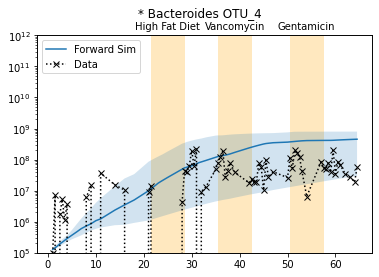

In [27]:
# Plot the forward sims, 25th-75th percentile
taxa = subj.taxa

low = np.percentile(M, q=25, axis=0)
high = np.percentile(M, q=75, axis=0)
med = np.percentile(M, q=50, axis=0)

oidx = 3

fig = plt.figure()
ax = fig.add_subplot(111)
ax.fill_between(times, y1=low[oidx, :], y2=high[oidx, :], alpha=0.2)
ax.plot(times, med[oidx,:], label='Forward Sim')
ax.plot(times, M_truth[oidx, :], label='Data', marker='x', color='black',
       linestyle=':')
ax.set_yscale('log')

md2.visualization.shade_in_perturbations(ax, perturbations=subj.perturbations, subj=subj)
ax.set_ylim(bottom=1e5, top=1e12)

ax.legend()

fig.suptitle(md2.taxaname_for_paper(taxa[oidx], taxa))
plt.show()

# Keystoneness
Calculate the keystoneness by using the `MDSINE2_Paper/keystoneness.py` script of the chain `uc100`.

Each line out table indicates which OTUs to leave out for that iteration of forward simulating to the steady state. Note that these are 0-based indecies for the OTUs.

In [28]:
# Make the leave out table - leave out each Cluster
os.makedirs('output/keystoneness', exist_ok=True)

mcmc = md2.BaseMCMC.load('output/mdsine2/uc100/mcmc.pkl')
clustering = mcmc.graph[STRNAMES.CLUSTERING_OBJ]
md2.generate_cluster_assignments_posthoc(clustering, set_as_value=True)
print(clustering)

txt = '\n'.join([','.join([str(oidx) for oidx in cluster.members]) for cluster in clustering])
f = open('output/keystoneness/leave_out_table.csv', 'w')
f.write(txt)
f.close()
print(txt)

!python ../keystoneness.py \
    --input output/mdsine2/uc0/mcmc.pkl \
    --study output/mdsine2/uc0/subjset.pkl \
    --leave-out-table output/keystoneness/leave_out_table.csv \
    --sep , \
    --simulation-dt 0.01 \
    --output-basepath output/keystoneness/ \
    --n-days 60

INFO:util.169: Number of clusters: 6
INFO:util.175: Clusters assigned: [0 0 1 0 0 3 3 1 0 5 0 2 3 3 4]


Clustering object (contains ability to change the cluster assignments), n_clusters: 6
Cluster 100525
	members: ['OTU_10']
	size: 1
Cluster 100563
	members: ['OTU_1', 'OTU_2', 'OTU_4', 'OTU_5', 'OTU_9', 'OTU_12']
	size: 6
Cluster 100564
	members: ['OTU_3', 'OTU_8']
	size: 2
Cluster 100565
	members: ['OTU_13']
	size: 1
Cluster 100566
	members: ['OTU_6', 'OTU_7', 'OTU_16', 'OTU_17']
	size: 4
Cluster 100567
	members: ['OTU_18']
	size: 1
9
0,1,3,4,8,10
2,7
11
5,6,12,13
14
(7, 15)
['OTU_1', 'OTU_2', 'OTU_3', 'OTU_4', 'OTU_5', 'OTU_6', 'OTU_7', 'OTU_8', 'OTU_9', 'OTU_10', 'OTU_12', 'OTU_13', 'OTU_16', 'OTU_17', 'OTU_18']


INFO:keystoneness.187: "all" provided as index. Iterating over each index
INFO:keystoneness.205: Forward simulating
INFO:keystoneness.210: Input is an MDSINE2.BaseMCMC object
INFO:keystoneness.242: not indexing out anything
INFO:keystoneness.81: 5/50 - 0.42211151123046875
INFO:keystoneness.81: 10/50 - 0.41199803352355957
INFO:keystoneness.81: 15/50 - 0.4181630611419678
INFO:keystoneness.81: 20/50 - 0.41403675079345703
INFO:keystoneness.81: 25/50 - 0.4129972457885742
INFO:keystoneness.81: 30/50 - 0.4090385437011719
INFO:keystoneness.81: 35/50 - 0.4139425754547119
INFO:keystoneness.81: 40/50 - 0.4134068489074707
INFO:keystoneness.81: 45/50 - 0.40643930435180664

['base', '9', '0,1,3,4,8,10', '2,7', '11', '5,6,12,13', '14']



INFO:keystoneness.233: indexing out [9]
INFO:keystoneness.81: 5/50 - 0.4040336608886719
INFO:keystoneness.81: 10/50 - 0.3900880813598633
INFO:keystoneness.81: 15/50 - 0.4070000648498535
INFO:keystoneness.81: 20/50 - 0.41298604011535645
INFO:keystoneness.81: 25/50 - 0.42455148696899414
INFO:keystoneness.81: 30/50 - 0.41803455352783203
INFO:keystoneness.81: 35/50 - 0.4349997043609619
INFO:keystoneness.81: 40/50 - 0.41620326042175293
INFO:keystoneness.81: 45/50 - 0.41028428077697754
INFO:keystoneness.233: indexing out [0, 1, 3, 4, 8, 10]
INFO:keystoneness.81: 5/50 - 0.397144079208374
INFO:keystoneness.81: 10/50 - 0.4075784683227539
INFO:keystoneness.81: 15/50 - 0.39203906059265137
INFO:keystoneness.81: 20/50 - 0.4066197872161865
INFO:keystoneness.81: 25/50 - 0.40378284454345703
INFO:keystoneness.81: 30/50 - 0.39121055603027344
INFO:keystoneness.81: 35/50 - 0.4009997844696045
INFO:keystoneness.81: 40/50 - 0.3969993591308594
INFO:keystoneness.81: 45/50 - 0.39367055892944336
INFO:keystonene

In [29]:
# Display the steady state table
df_steady_state = pd.read_csv('output/keystoneness/uc-toy-dataset/steady-state-table.tsv',
                sep='\t', index_col=0)
df_steady_state.head()

,OTU_1,OTU_2,OTU_3,OTU_4,OTU_5,OTU_6,OTU_7,OTU_8,OTU_9,OTU_10,OTU_12,OTU_13,OTU_16,OTU_17,OTU_18
base,3.093428e+10,1.815624e+10,4.236230e+10,89692.651509,9.435731e+09,1.315288e+10,8.232234e+09,5.233964e+09,3.692423e+06,1690.799349,3.812976e+09,3.530125e+07,4.806152e+09,3.075512e+09,6.914767e+08
9,3.093448e+10,1.815649e+10,4.236230e+10,89692.704823,9.435806e+09,1.315282e+10,8.232218e+09,5.233964e+09,3.692425e+06,NaN,3.813007e+09,3.530125e+07,4.806110e+09,3.075499e+09,6.914773e+08
"0,1,3,4,8,10",NaN,NaN,4.236230e+10,NaN,NaN,4.257117e+10,9.548776e+10,5.233964e+09,NaN,1690.799349,NaN,3.530125e+07,1.081247e+10,5.706281e+09,6.914767e+08
"2,7",3.093428e+10,1.815624e+10,NaN,89692.651509,9.435731e+09,1.315288e+10,8.232234e+09,NaN,3.692423e+06,1690.799349,3.812976e+09,3.530125e+07,4.806152e+09,3.075512e+09,6.914767e+08
11,3.092293e+10,1.814069e+10,4.236230e+10,89692.527527,9.431990e+09,1.316054e+10,8.241588e+09,5.233964e+09,3.692383e+06,1692.466952,3.811552e+09,NaN,4.808368e+09,3.077318e+09,6.915369e+08


In [30]:
# Display the keystoneness table
df_keystoneness = pd.read_csv('output/keystoneness/uc-toy-dataset/keystoneness.tsv',
                sep='\t', index_col=0)
df_keystoneness.head()

,l2 distance
9,3.523628e+05
"0,1,3,4,8,10",1.034113e+11
"2,7",6.276099e-06
11,2.331681e+07
"5,6,12,13",0.000000e+00


# Perturbation analysis

In [31]:
!python ../perturbation_analysis.py \
    --input output/mdsine2/uc0/mcmc.pkl \
    --study output/mdsine2/uc0/subjset.pkl \
    --leave-out-table output/keystoneness/leave_out_table.csv \
    --perturbation Vancomycin \
    --output-basepath output/keystoneness/pert_analysis \
    --start-perturbation 60 \
    --end-perturbation 120 \
    --n-days 180

<class 'mdsine2.pylab.base.Perturbations'>
0.01
120.0
60.0
180
18001


INFO:perturbation_analysis.149: "all" provided as index. Iterating over each index
INFO:perturbation_analysis.169: Forward simulating
INFO:perturbation_analysis.174: Input is an MDSINE2.BaseMCMC object
INFO:perturbation_analysis.222: indexing out [9]
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:perturbation_analysis.57: 5/50 - 1.3220031261444092
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:perturbation_analysis.57: 10/50 - 1.2853209972381592
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO

0.01
120.0
60.0
180
18001
0.01
120.0
60.0
180
18001
0.01
120.0
60.0
180
18001
0.01
120.0
60.0
180
18001


INFO:dynamics.275: Simulating 10000/18001
INFO:perturbation_analysis.57: 20/50 - 1.2921624183654785
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:perturbation_analysis.57: 25/50 - 1.2701189517974854
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:perturbation_analysis.57: 30/50 - 1.2671217918395996
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:perturbation_analysis.57: 35/50 - 1.3028650283813477
INFO:dynamics.275: Simulating 10000/18001
INFO:dynamics.275: Simulating 10000/18001
INFO:dynami


0.01
120.0
60.0
180
18001
